In [1]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline 

# Parte 1: Torque magnético em função da corrente nas bobinas de Helmoltz

## Dados:


In [2]:
print((np.power(4/5,3/2)*154*4*np.pi*1e-7)/(200e-3))

0.0006923657398913741


In [3]:
#Corrente fixa na espira: 2.504 A
#"Residuo": i_bobina= 0 A

#Dados
i_bobina = [0.251,0.494,0.737,1.006,1.251,1.501,1.751,1.999,2.248,2.501,2.753,2.991] # em A
i_bobina = np.array(i_bobina)

forca_1 = [0.15,0.29,0.42,0.60,0.79,0.96,1.09,1.29,1.48,1.60,1.75,1.90] # em mN
forca_1 = np.array(forca_1)
incF1 = np.full(len(forca_1),0.05)


### Incerteza da corrente:

$\pm(1.0\% + 2D)$

In [4]:
incI_bobina = [float('{:g}'.format(float('{:.2g}'.format(i*0.01 + 2*0.001)))) for i in i_bobina] 

### Calculando o torque e sua incerteza:

$\mathbf{\tau} = 2\mathbf(r)\times \mathbf{F}$, ou seja, $\tau = d \ F$ (d=diâmetro)

Incerteza:

$$\sigma_{\tau} = \bigg|\frac{\partial \tau}{\partial F}\bigg|\sigma_F$$
$$\sigma_{\tau} = \bigg|\frac{\partial d \ F}{\partial  F}\bigg|\sigma_F$$
$$\sigma_{\tau} = d\sigma_F$$

In [5]:
torque1 = 0.12*forca_1
print(torque1)

incT1 = 0.12*incF1

[0.018  0.0348 0.0504 0.072  0.0948 0.1152 0.1308 0.1548 0.1776 0.192
 0.21   0.228 ]


### Gráfico dos dados brutos:

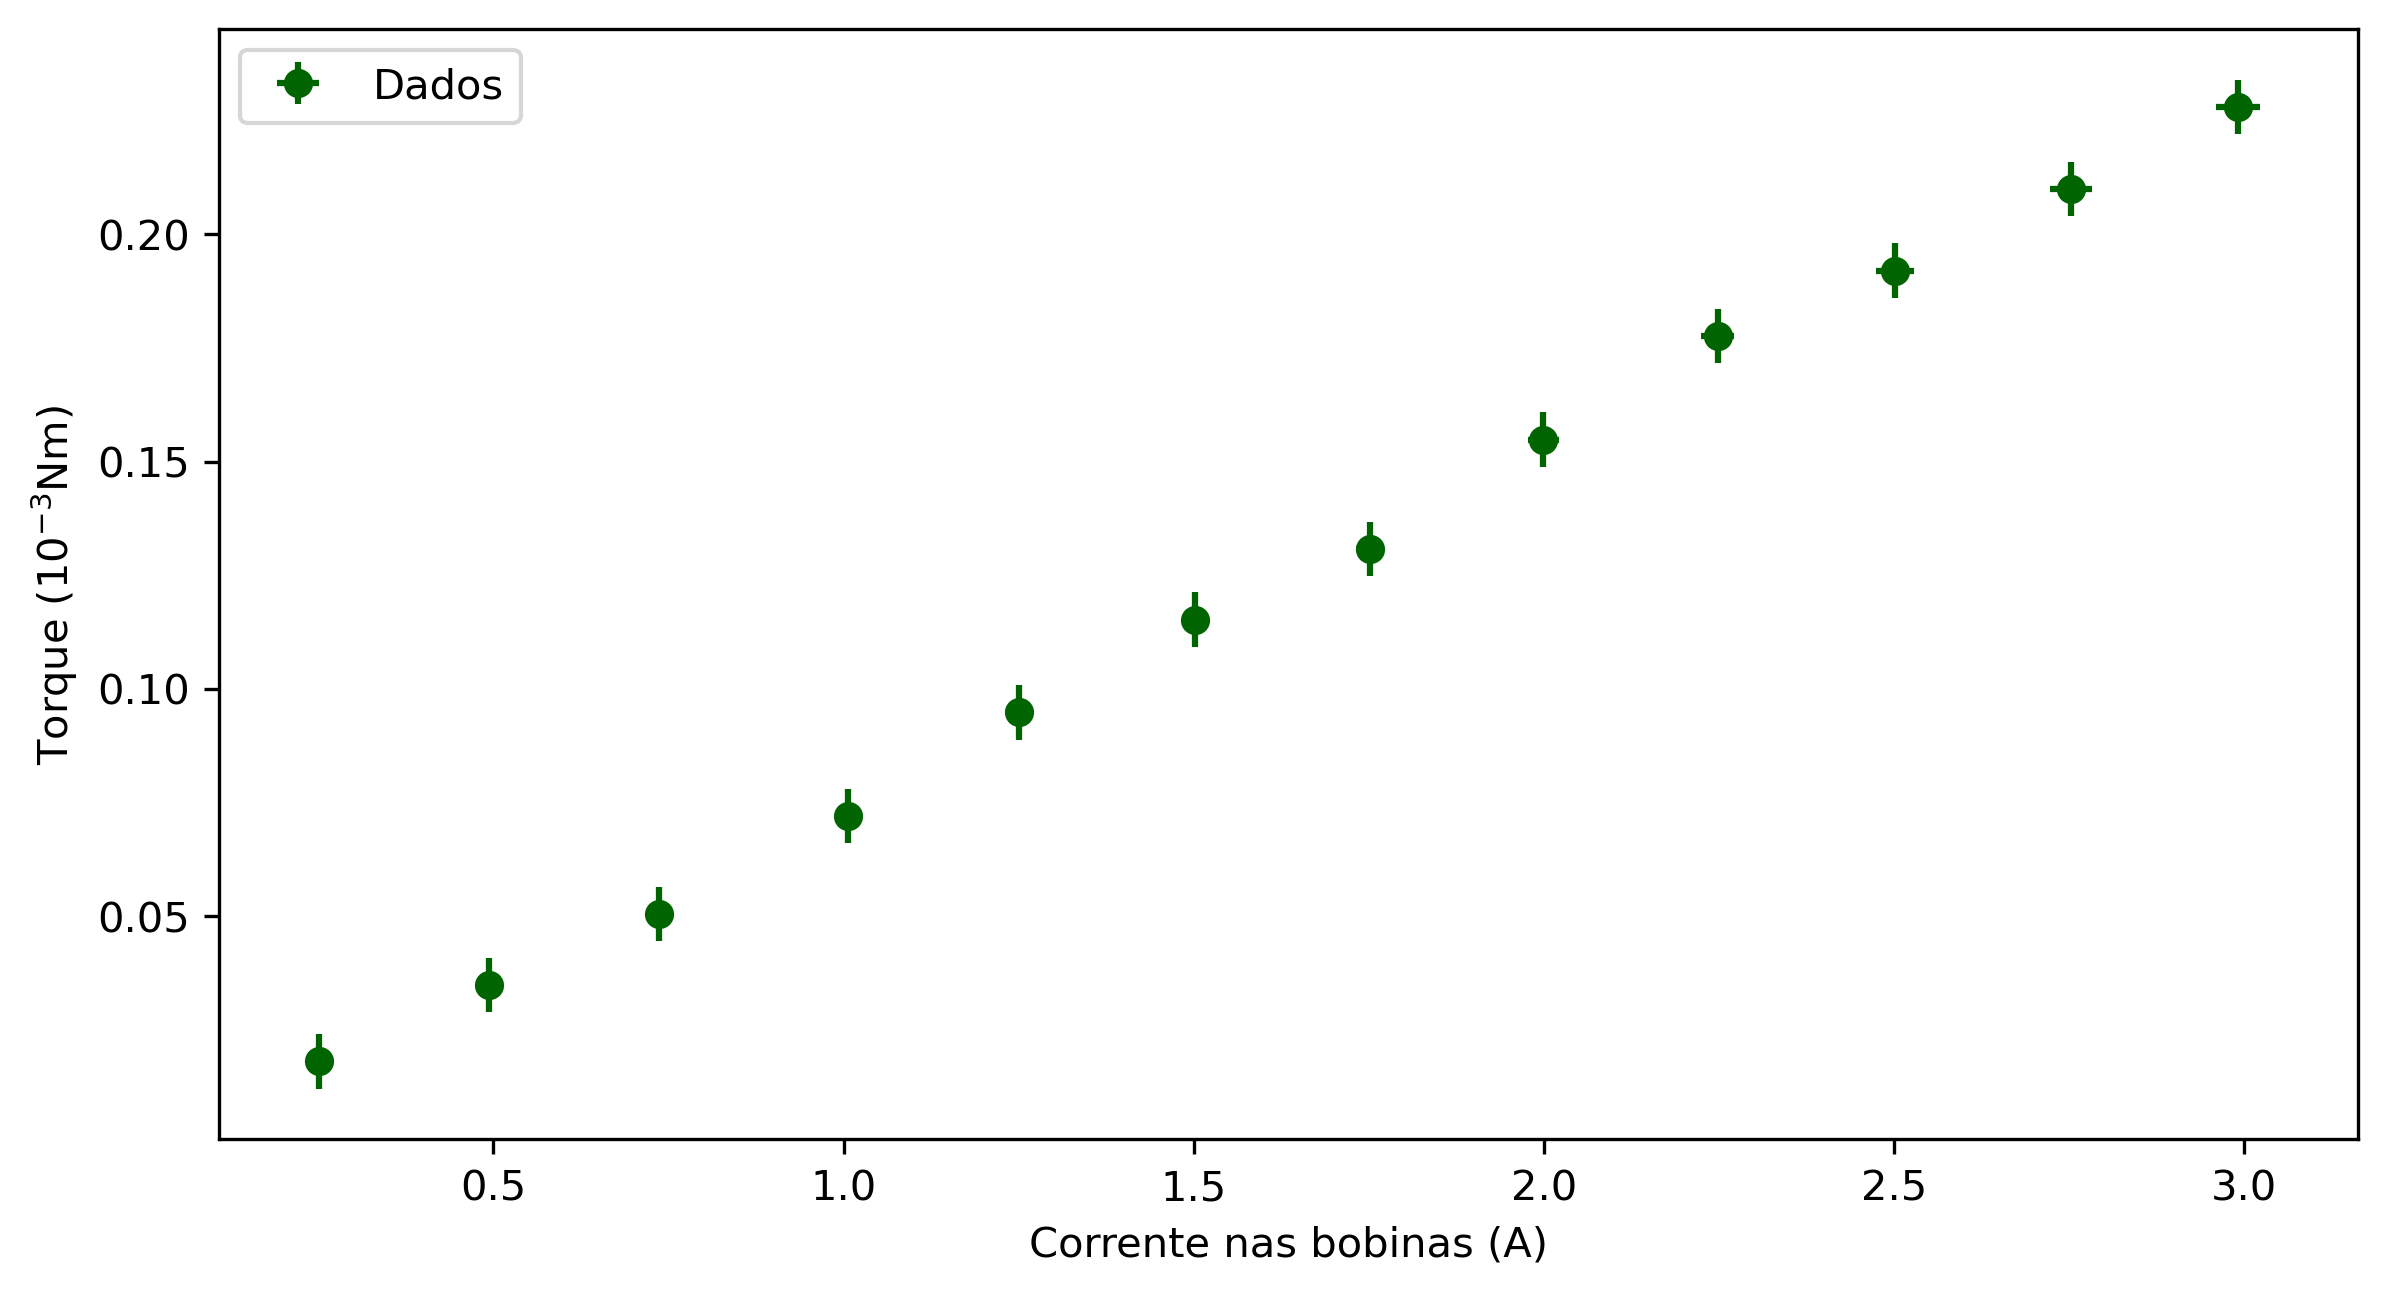

In [6]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.errorbar(i_bobina,torque1,incT1,incI_bobina, 'o', color = 'darkgreen', label = 'Dados')
plt.xlabel('Corrente nas bobinas (A)')
plt.ylabel('Torque ($10^{-3}$Nm)')
plt.legend()
plt.show()

### Transferência de incertezas:

O modelo teórico é $\tau = c \ I_e \ I_b \ n \ A$

$$\sigma_\tau = \sqrt{\sigma_{\tau \ 0}^2 + \bigg(\frac{\partial \tau}{\partial I_b}\bigg)^2\sigma^2_{I_b} +\bigg(\frac{\partial \tau}{\partial I_e}\bigg)^2\sigma^2_{I_e} }$$
$$\sigma_\tau = \sqrt{\sigma_{\tau \ 0}^2 + \bigg(\frac{\partial \tau}{\partial I_b}\bigg)^2\sigma^2_{I_b} +\bigg(\frac{\partial c \ I_e \ I_b \ n \ A}{\partial I_e}\bigg)^2\sigma^2_{I_e} }$$
$$\sigma_\tau = \sqrt{\sigma_{\tau \ 0}^2 + \bigg(\frac{\partial \tau}{\partial I_b}\bigg)^2\sigma^2_{I_b} +\bigg( c  \ I_b \ n \ A\bigg)^2\sigma^2_{I_e} }$$

In [7]:
c = (np.power(4/5,3/2)*154*4*np.pi*1e-7)/(200e-3) #7.433e-4 #Verificar esse valor
i_e = 2.504
incIE = 0.01*i_e + 2*0.001
area = np.pi*(60e-3**2)
n=3

fit = np.polyfit(i_bobina, torque1,1)

inctransf_T1 = np.sqrt(np.power(incT1,2) + np.power(fit[0]*np.array(incI_bobina),2) + np.power(n*c*area*i_bobina*incIE,2) )

inctransf_T1 = [float('{:g}'.format(float('{:.2g}'.format(i)))) for i in inctransf_T1]
print(inctransf_T1)

[0.006, 0.006, 0.006, 0.0061, 0.0061, 0.0061, 0.0062, 0.0062, 0.0063, 0.0064, 0.0064, 0.0065]


### Ajuste através do MMQ:

In [8]:
fitpars, cov_pars = np.polyfit(i_bobina,torque1,1,w=np.power(inctransf_T1,-1),cov='True')

coef_angular = fitpars[0]
coef_linear = fitpars[1]
sigma_angular = np.sqrt(cov_pars[0][0])
sigma_linear = np.sqrt(cov_pars[1][1])

sigma_angular = float('{:g}'.format(float('{:.2g}'.format(sigma_angular))))
sigma_linear = float('{:g}'.format(float('{:.2g}'.format(sigma_linear))))

                     
print('Coeficiente angular: %.5f +- %.5f (10^{-3}Nm/A)' % (coef_angular ,sigma_angular))
print('Coeficiente linear: %.4f +- %.4f (10^{-3}Nm)' %(coef_linear,sigma_linear))


Coeficiente angular: 0.07836 +- 0.00093 (10^{-3}Nm/A)
Coeficiente linear: -0.0040 +- 0.0017 (10^{-3}Nm)


In [9]:
print(coef_angular*1e-3/(n*c*area))

3.335578678238887


### Gráfico do ajuste:

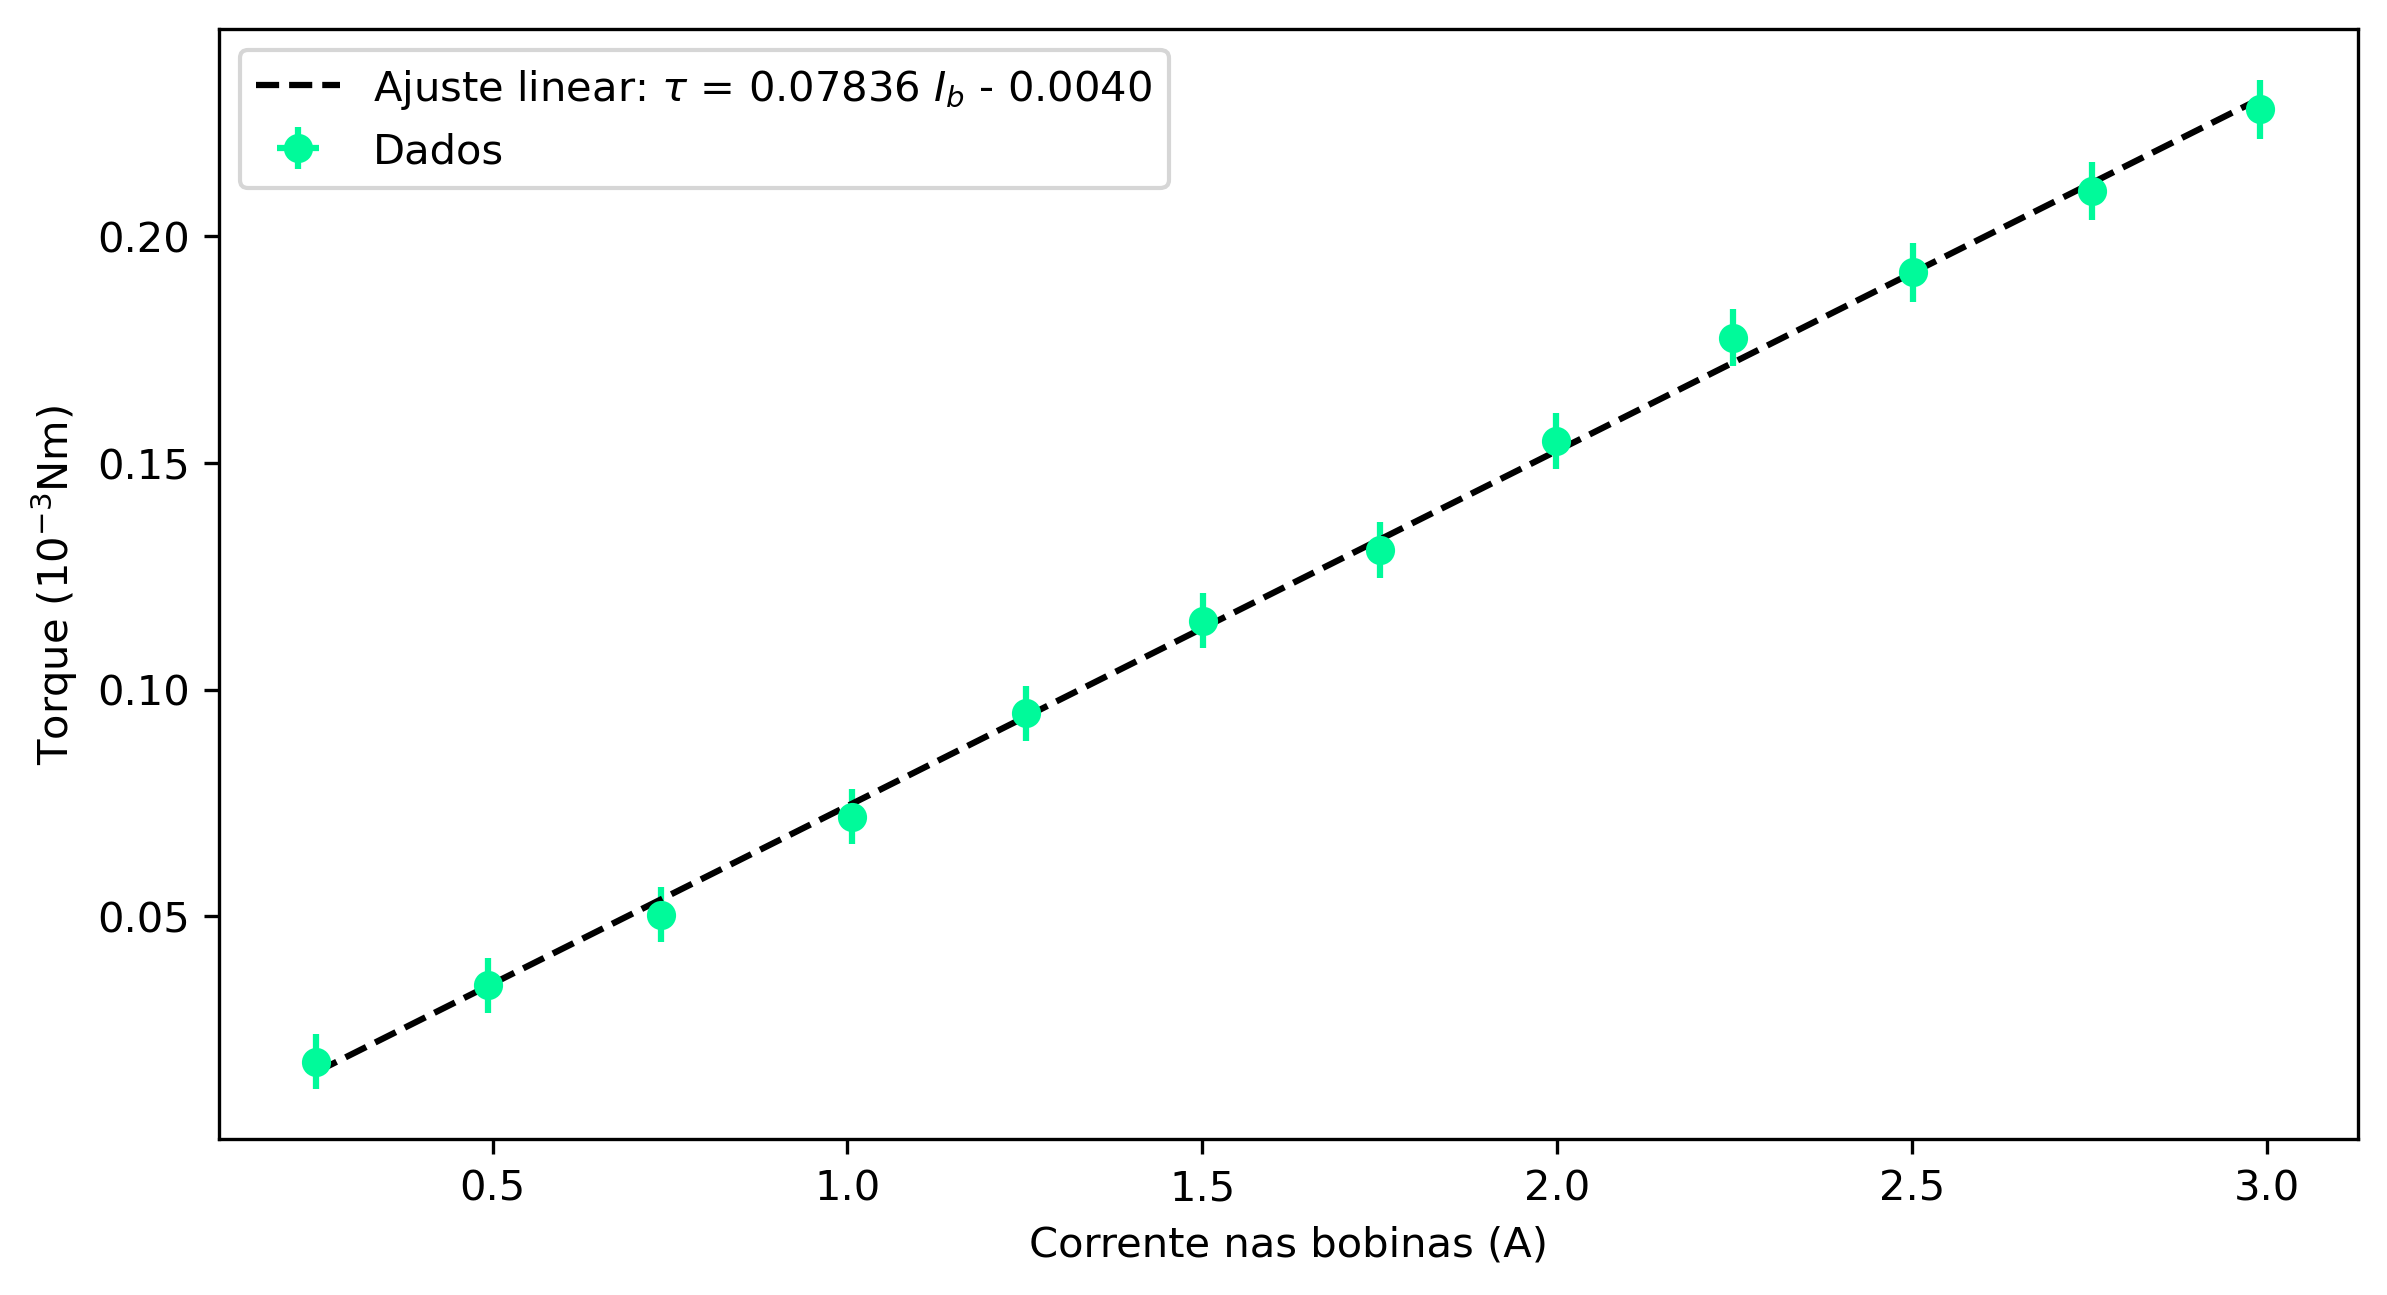

In [10]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.errorbar(i_bobina,torque1,inctransf_T1,0, 'o', color = 'Mediumspringgreen', label = 'Dados')
plt.plot(i_bobina,np.array(i_bobina)*coef_angular + coef_linear, color ='black', ls = '--', label = r'Ajuste linear: $\tau$ = %.5f $I_{b}$ - %.4f' % (coef_angular,abs(coef_linear)))
plt.xlabel('Corrente nas bobinas (A)')
plt.ylabel('Torque ($10^{-3}$Nm)')
plt.legend()
plt.show()

### Qualidade do ajuste:


In [11]:
#Calulando chi^2_red
yhat = np.polyval(fitpars, i_bobina)
chi_squared = np.sum(((yhat - torque1)/inctransf_T1) ** 2)
chi2_red = chi_squared/(len(i_bobina)-2)

#Imprimindo o resultado
print("chi^2_red = %.3f" % chi2_red)

chi^2_red = 0.199


### Gráfico de resíduos:

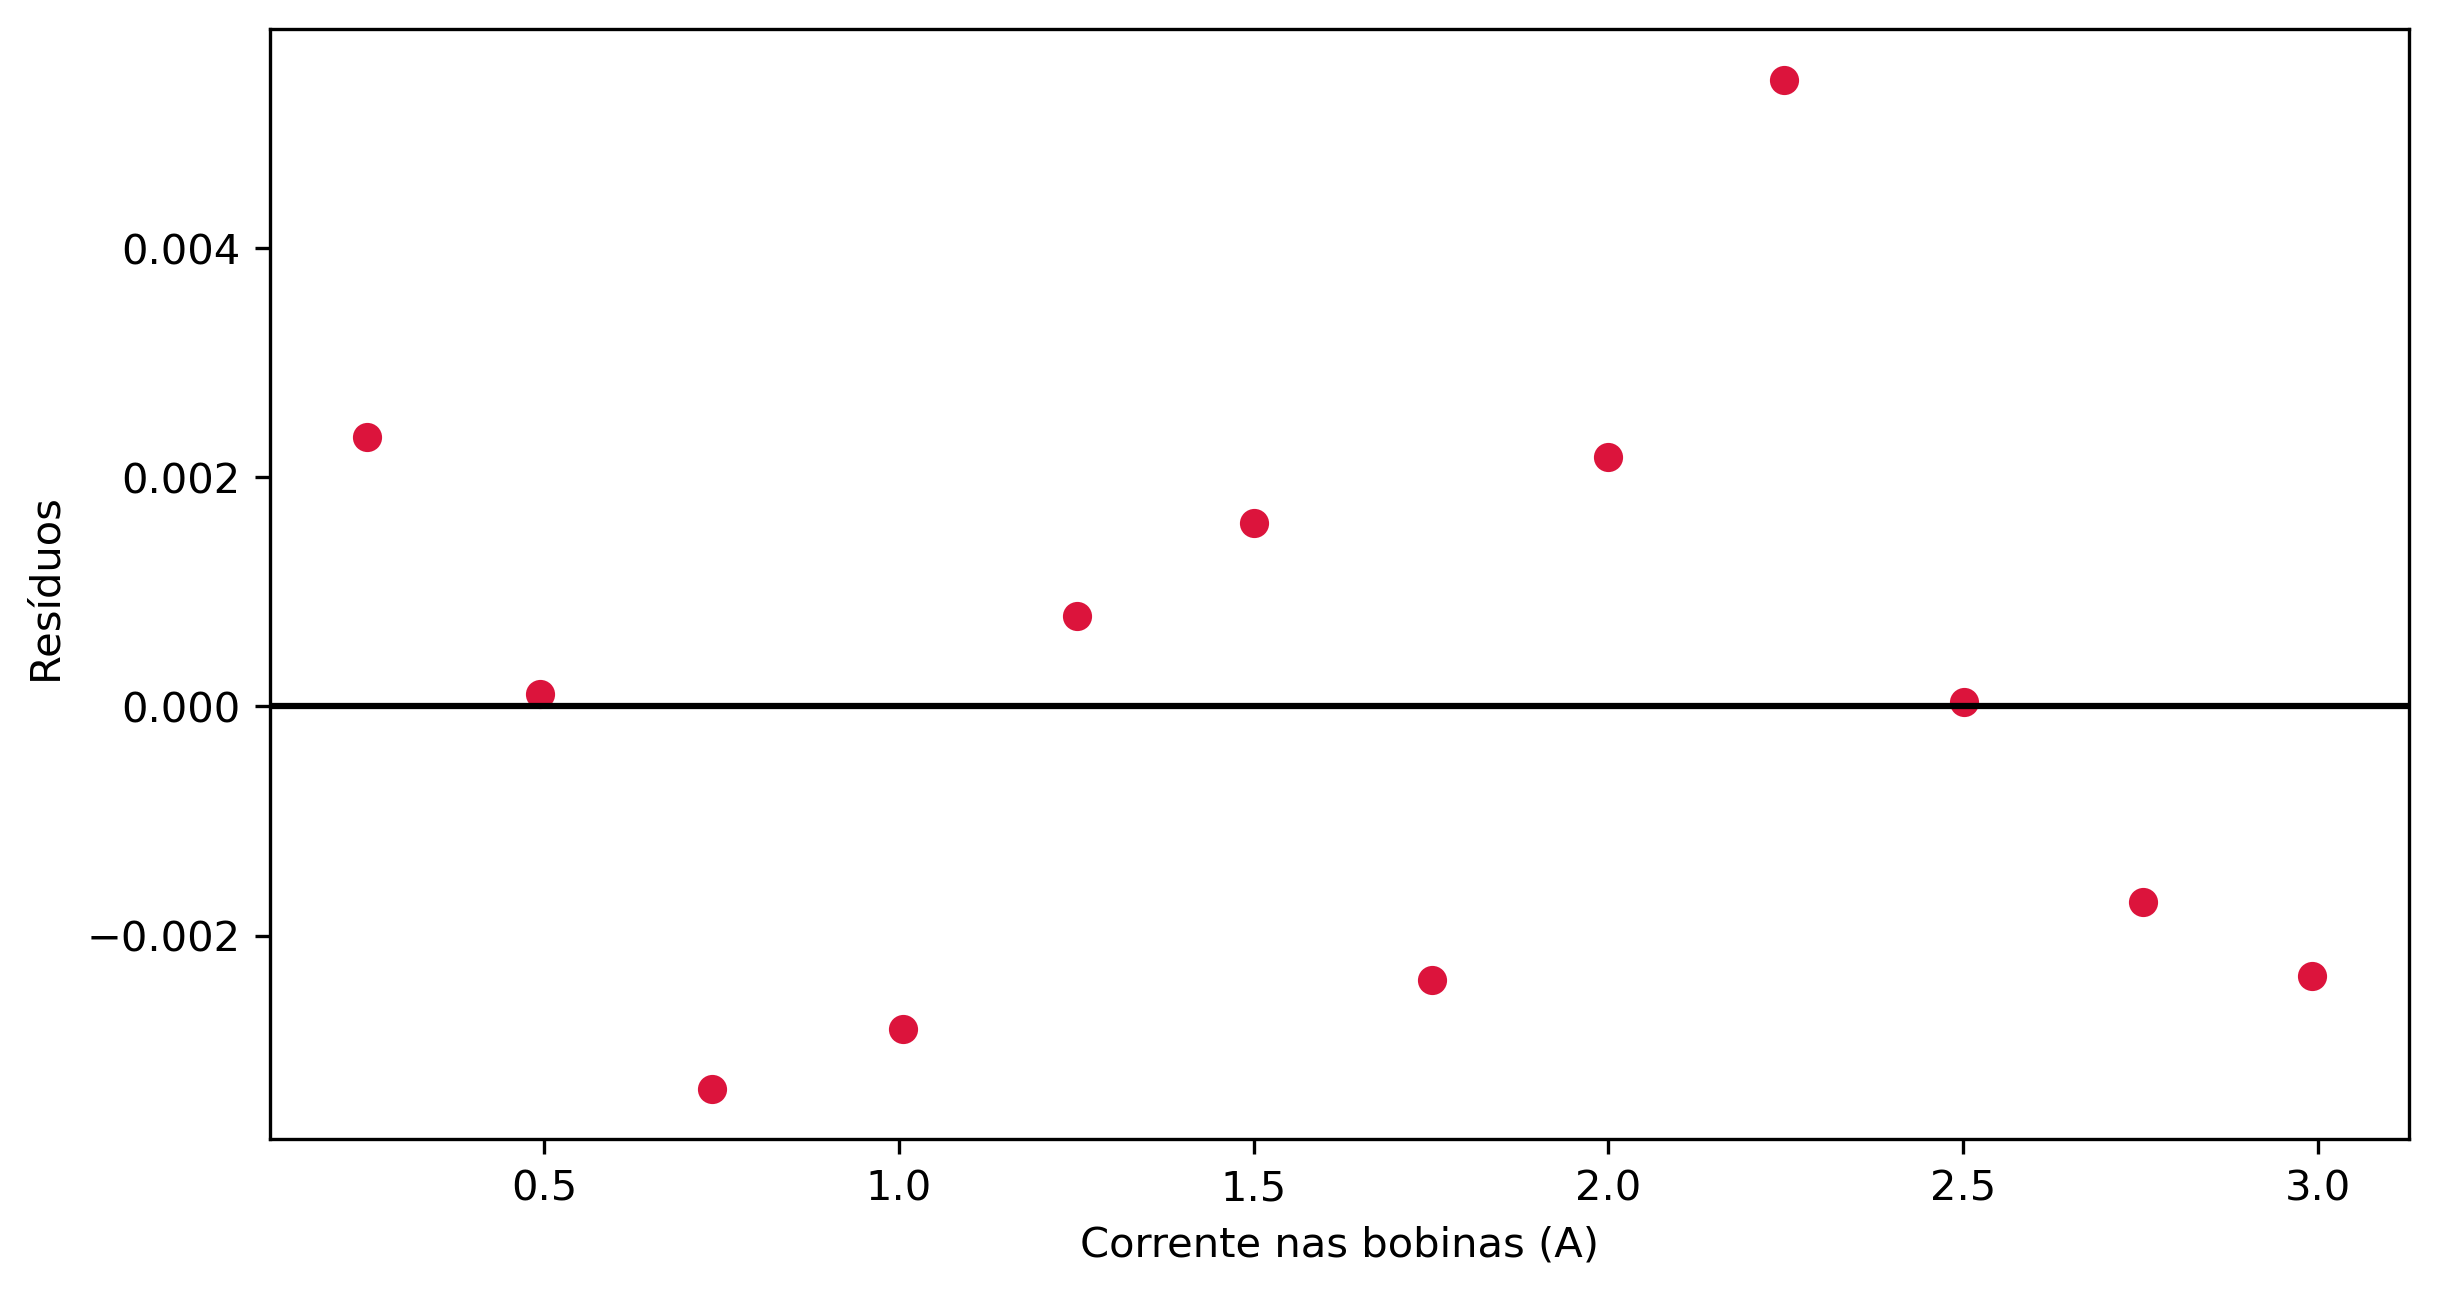

In [12]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.scatter(np.array(i_bobina),np.array(torque1)-np.array(i_bobina)*coef_angular - coef_linear, color = 'crimson')
plt.axhline(y=0, color='k', linestyle='-')
plt.ylabel("Resíduos ")
plt.xlabel('Corrente nas bobinas (A)')

plt.show()

# Parte 2: Torque magnético em função de n° de voltas na espiras

## Dados:

In [13]:
#Corrente fixada na espira: 2.003 A
#Corrente fixada na bobina: 2.002 A
#Espira de 

#Dados:
forca_2 = [0.90,0.67,0.35] # em mN
forca_2 = np.array(forca_2)
incF2 = np.full(len(forca_2), 0.05)

voltas = [3,2, 1] 
voltas = np.array(voltas)
 

### Calculando o torque e sua incerteza

In [14]:
torque2 = 0.12*forca_2

incT2 = 0.12*incF2

### Gráfico dos dados brutos:


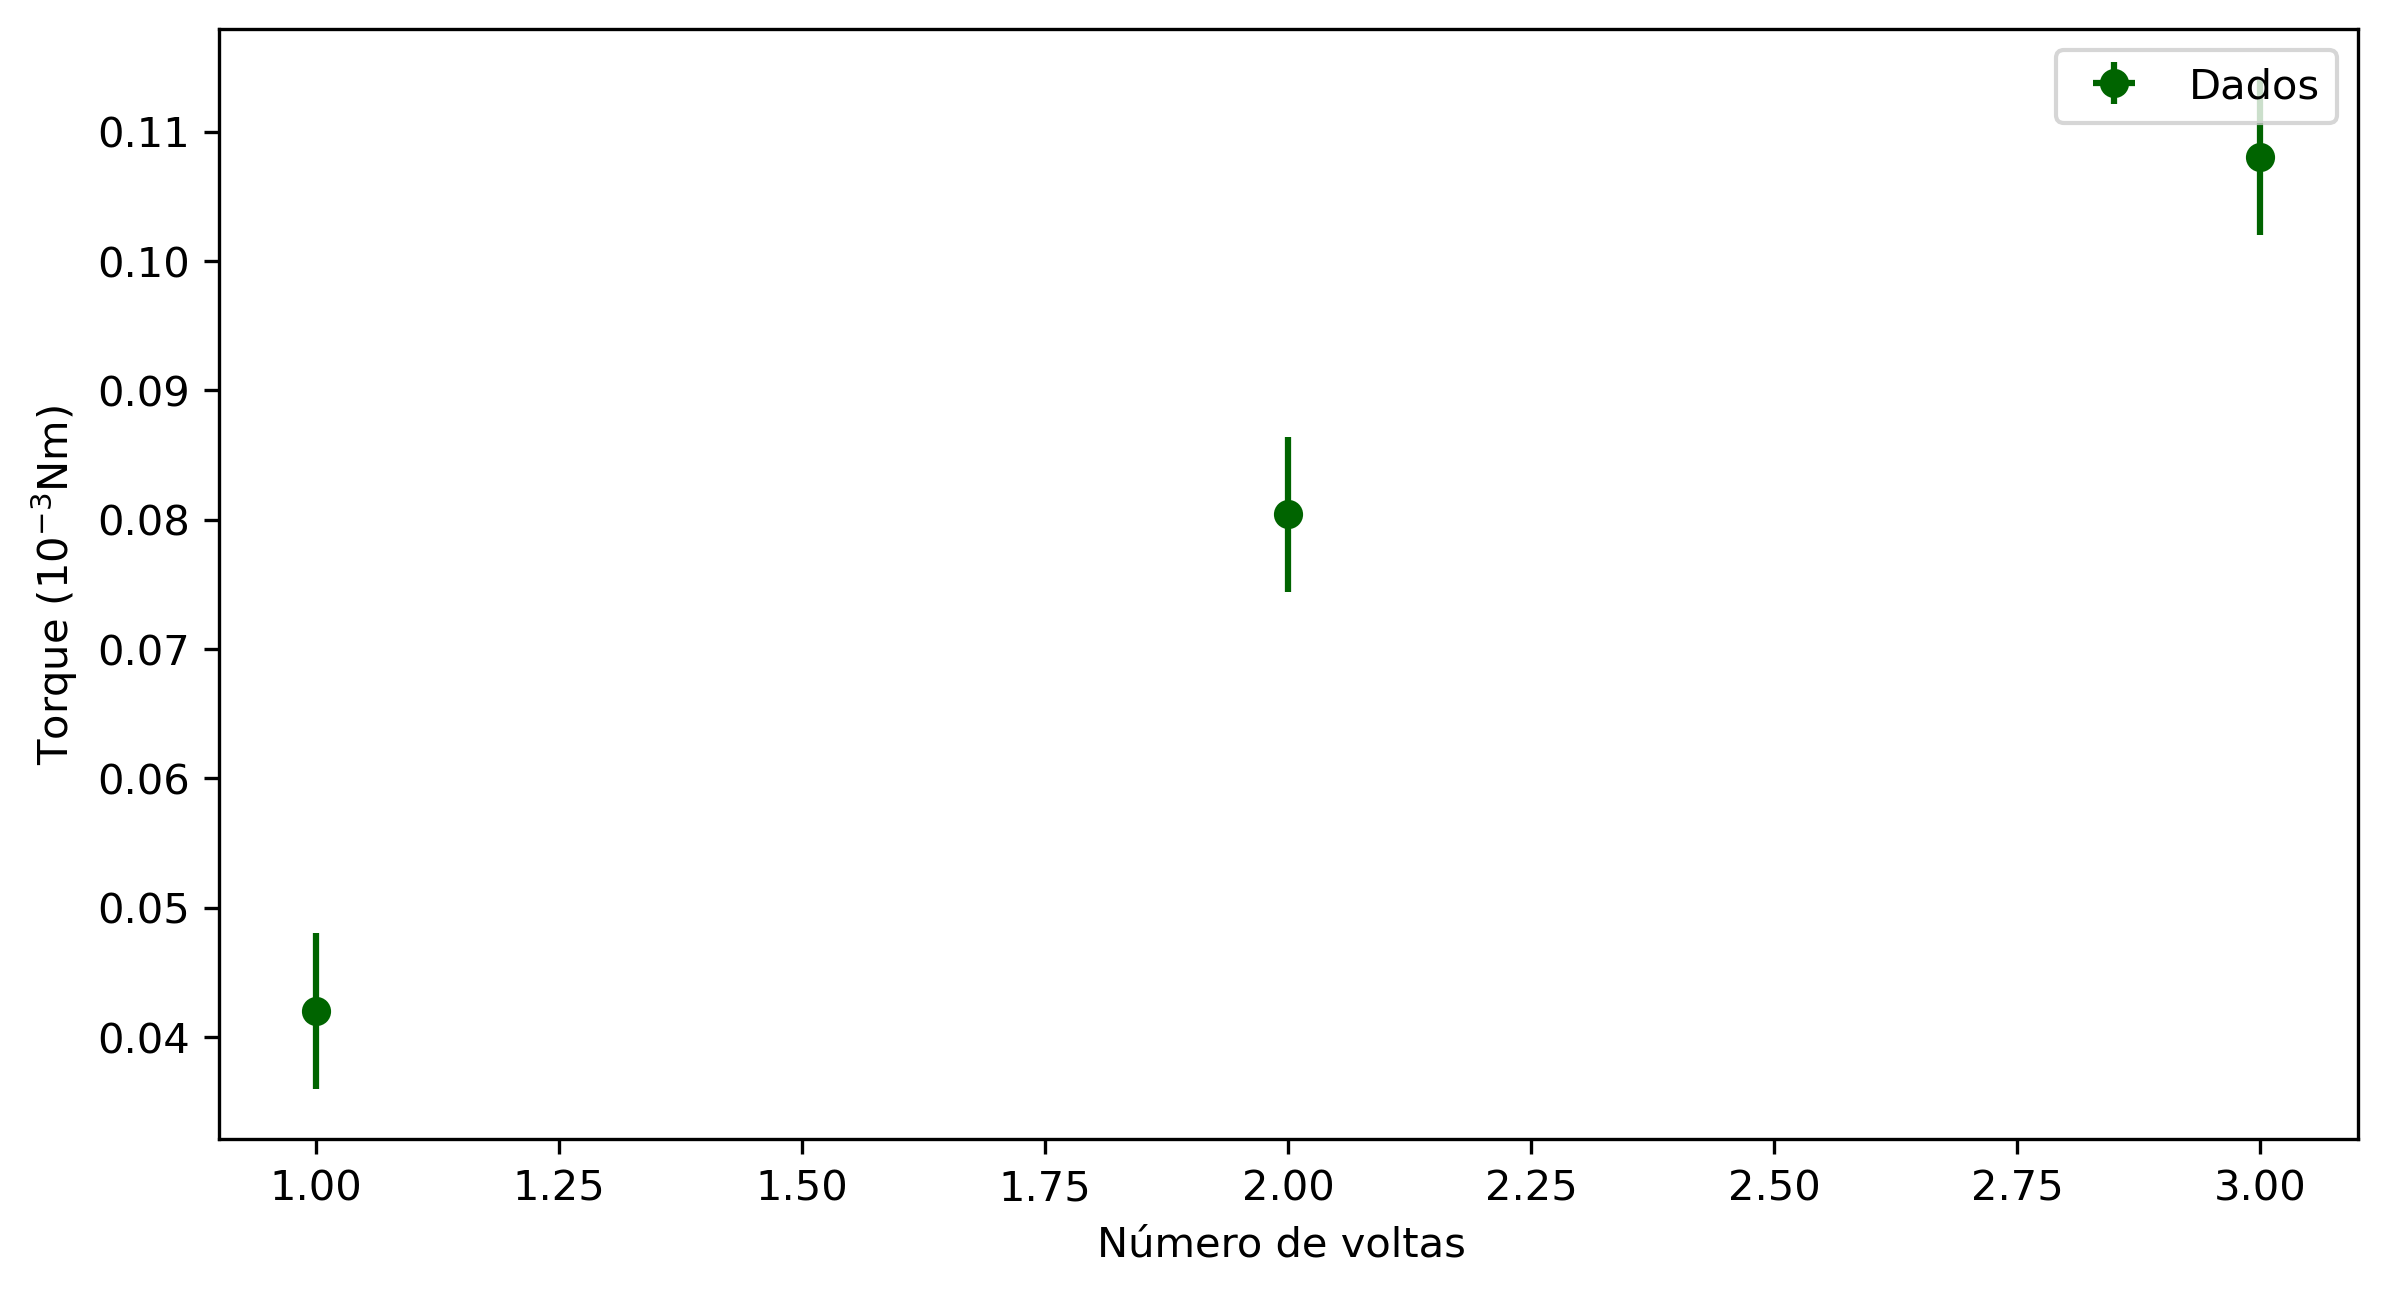

In [15]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.errorbar(voltas,torque2,incT2,0, 'o', color = 'darkgreen', label = 'Dados')
plt.xlabel('Número de voltas ')
plt.ylabel('Torque ($10^{-3}$Nm)')
plt.legend()
plt.show()

### Transferência de incerteza:

O modelo teórico é $\tau = c \ I_e \ I_b \ n \ A$

$$\sigma_\tau = \sqrt{\sigma_{\tau \ 0}^2 + \bigg(\frac{\partial \tau}{\partial I_b}\bigg)^2\sigma^2_{I_b} +\bigg(\frac{\partial \tau}{\partial I_e}\bigg)^2\sigma^2_{I_e} }$$
$$\sigma_\tau = \sqrt{\sigma_{\tau \ 0}^2 + \bigg(\frac{\partial c \ I_e \ I_b \ n \ A}{\partial I_b}\bigg)^2\sigma^2_{I_b} +\bigg(\frac{\partial c \ I_e \ I_b \ n \ A}{\partial I_e}\bigg)^2\sigma^2_{I_e} }$$
$$\sigma_\tau = \sqrt{\sigma_{\tau \ 0}^2 + \bigg(c \ I_e  \ n \ A\bigg)^2\sigma^2_{I_b} +\bigg( c  \ I_b \ n \ A\bigg)^2\sigma^2_{I_e} }$$


In [16]:

i_es = 2.003 #A
incIES = 0.01*i_es + 2*0.001 #A
i_b = 2.002 #A
incIB = 0.01*i_b + 2*0.001 #A

inctransf_T2 = np.sqrt(np.power(incT2,2)  + np.power(voltas*c*area*i_b*incIES,2) + np.power(voltas*c*area*i_es*incIB,2) )

inctransf_T2 = [float('{:g}'.format(float('{:.2g}'.format(i)))) for i in inctransf_T2]
print(inctransf_T2)

[0.006, 0.006, 0.006]


### Ajuste através do MMQ

In [17]:
fitpars2, cov_pars2 = np.polyfit(voltas,torque2,1,w=np.power(inctransf_T2,-1),cov='True')

coef_angular2 = fitpars2[0]
coef_linear2 = fitpars2[1]
sigma_angular2 = np.sqrt(cov_pars2[0][0])
sigma_linear2 = np.sqrt(cov_pars2[1][1])

sigma_angular2 = float('{:g}'.format(float('{:.2g}'.format(sigma_angular2))))
sigma_linear2 = float('{:g}'.format(float('{:.2g}'.format(sigma_linear2))))

                     
print('Coeficiente angular: %.4f +- %.4f (10^{-3}Nm)' % (coef_angular2 ,sigma_angular2))
print('Coeficiente linear: %.4f +- %.4f (10^{-3}Nm)' %(coef_linear2,sigma_linear2))

Coeficiente angular: 0.0330 +- 0.0031 (10^{-3}Nm)
Coeficiente linear: 0.0108 +- 0.0067 (10^{-3}Nm)


In [18]:
print('A = ', coef_angular2*1e-3/(c*i_es*i_b))
print(area)

A =  0.011885934913342895
0.011309733552923255


### Gráfico do ajuste

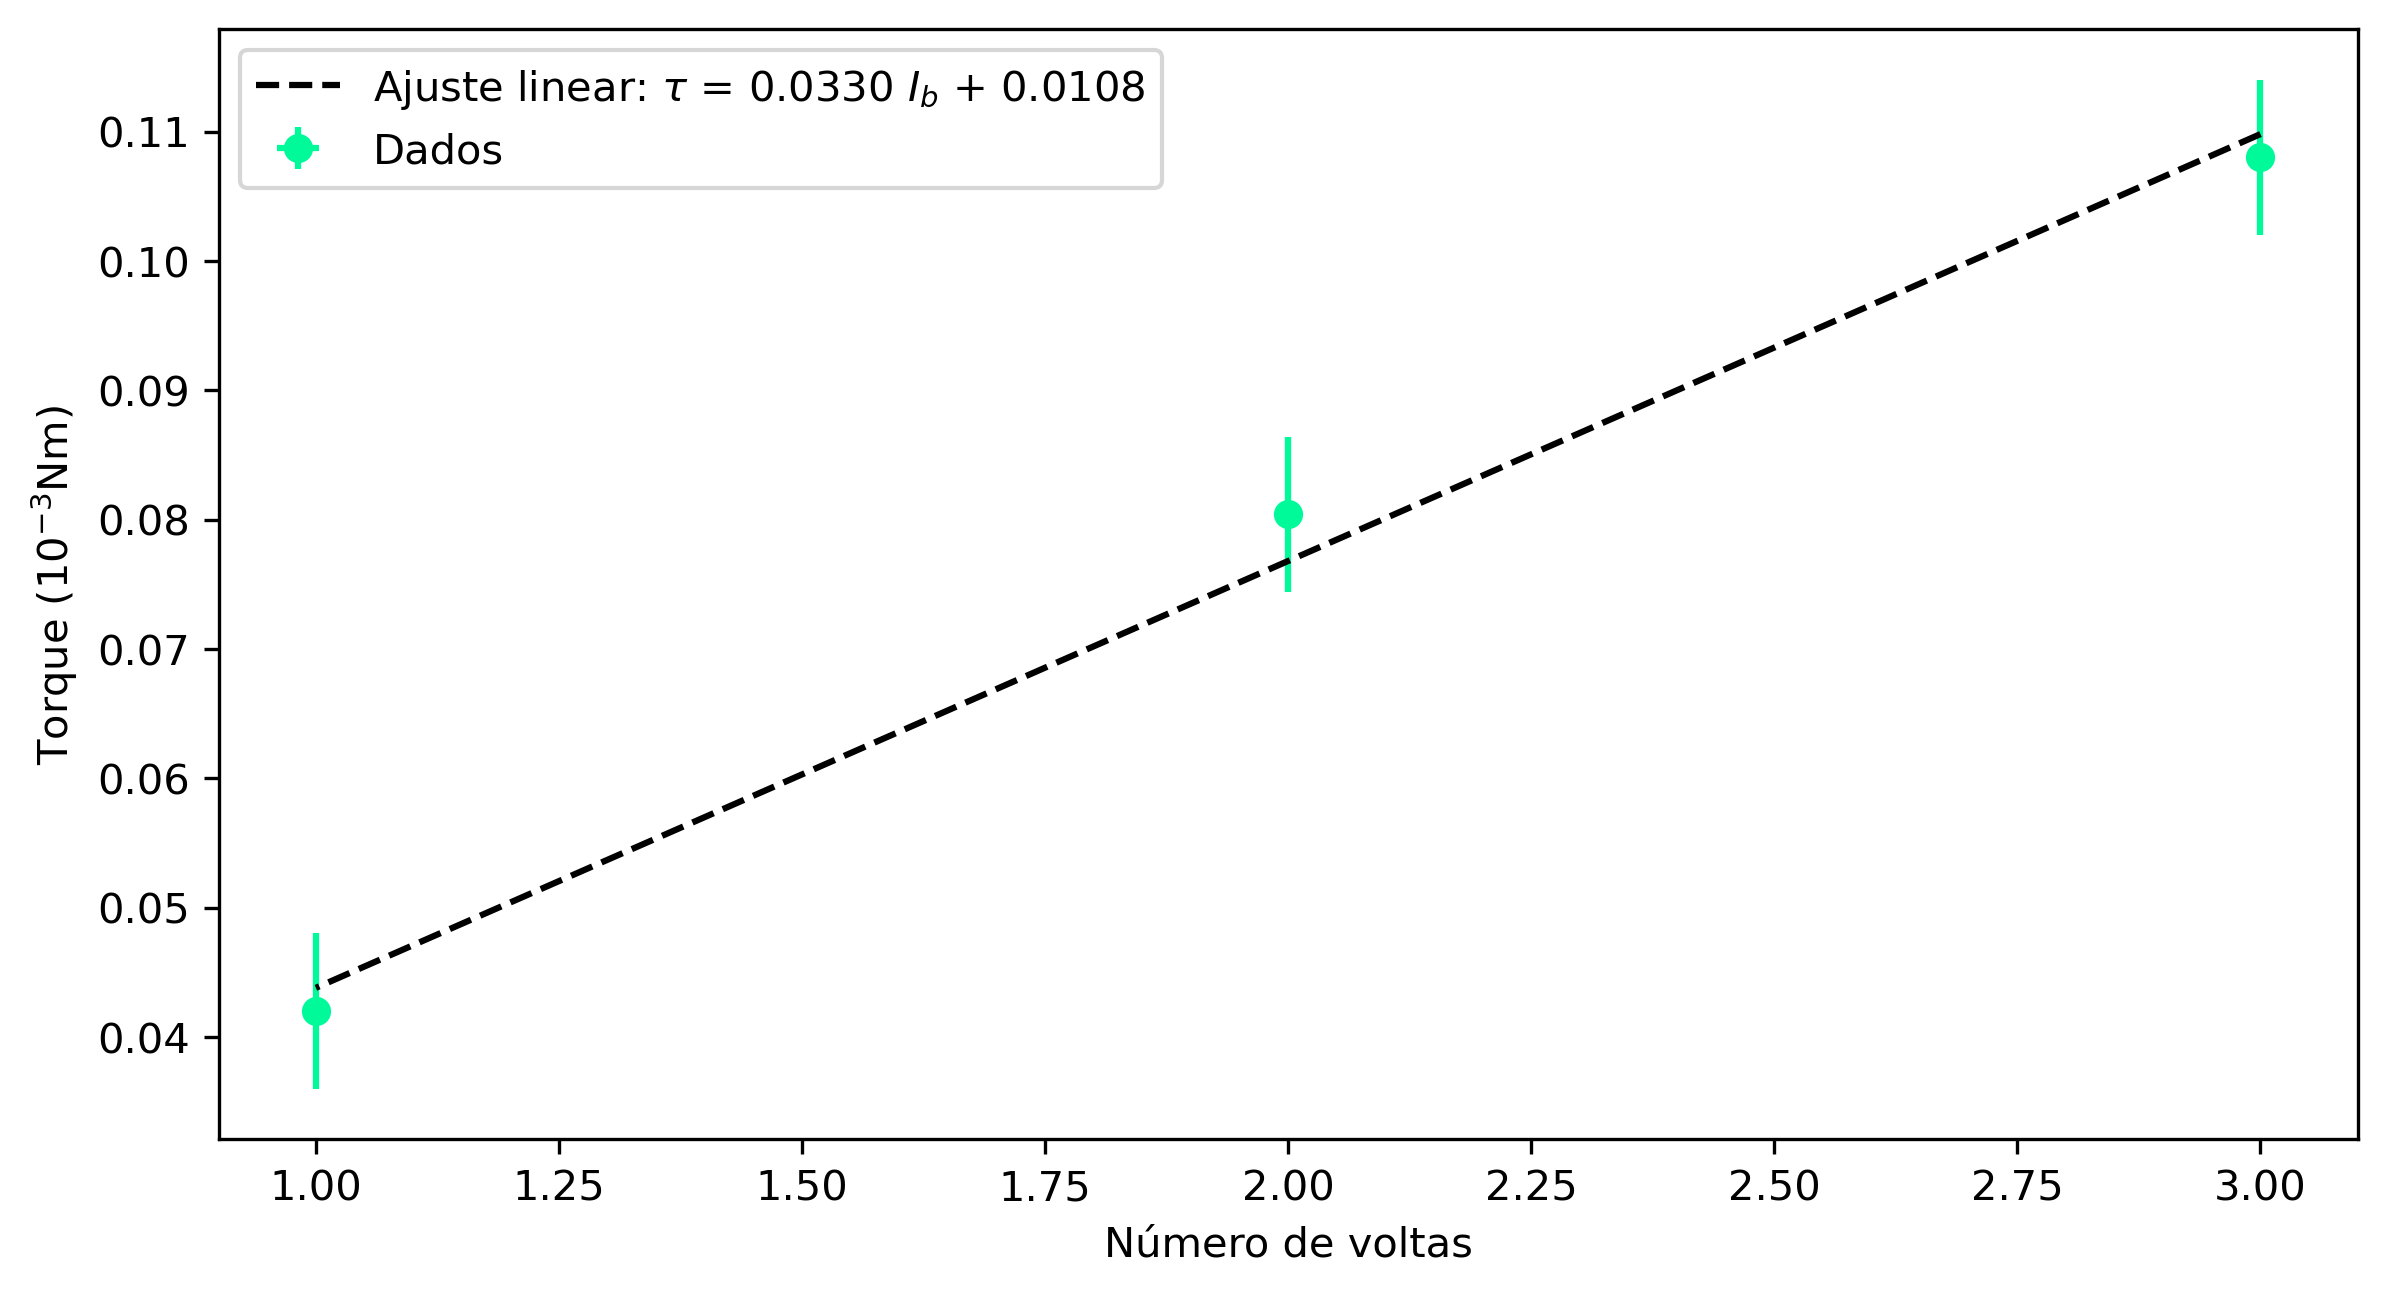

In [19]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.errorbar(voltas,torque2,inctransf_T2,0, 'o', color = 'Mediumspringgreen', label = 'Dados')
plt.plot(voltas,np.array(voltas)*coef_angular2 + coef_linear2, color ='black', ls = '--', label = r'Ajuste linear: $\tau$ = %.4f $I_{b}$ + %.4f' % (coef_angular2,abs(coef_linear2)))
plt.xlabel('Número de voltas')
plt.ylabel('Torque ($10^{-3}$Nm)')
plt.legend()
plt.show()

### Qualidade do ajuste


In [20]:
#Calulando chi^2_red
yhat2 = np.polyval(fitpars2, voltas)
chi_squared2 = np.sum(((yhat2 - torque2)/inctransf_T2) ** 2)
chi2_red2 = chi_squared2/(len(voltas)-2)

#Imprimindo o resultado
print("chi^2_red = %.3f" % chi2_red2)

chi^2_red = 0.540


### Gráfico de resíduos

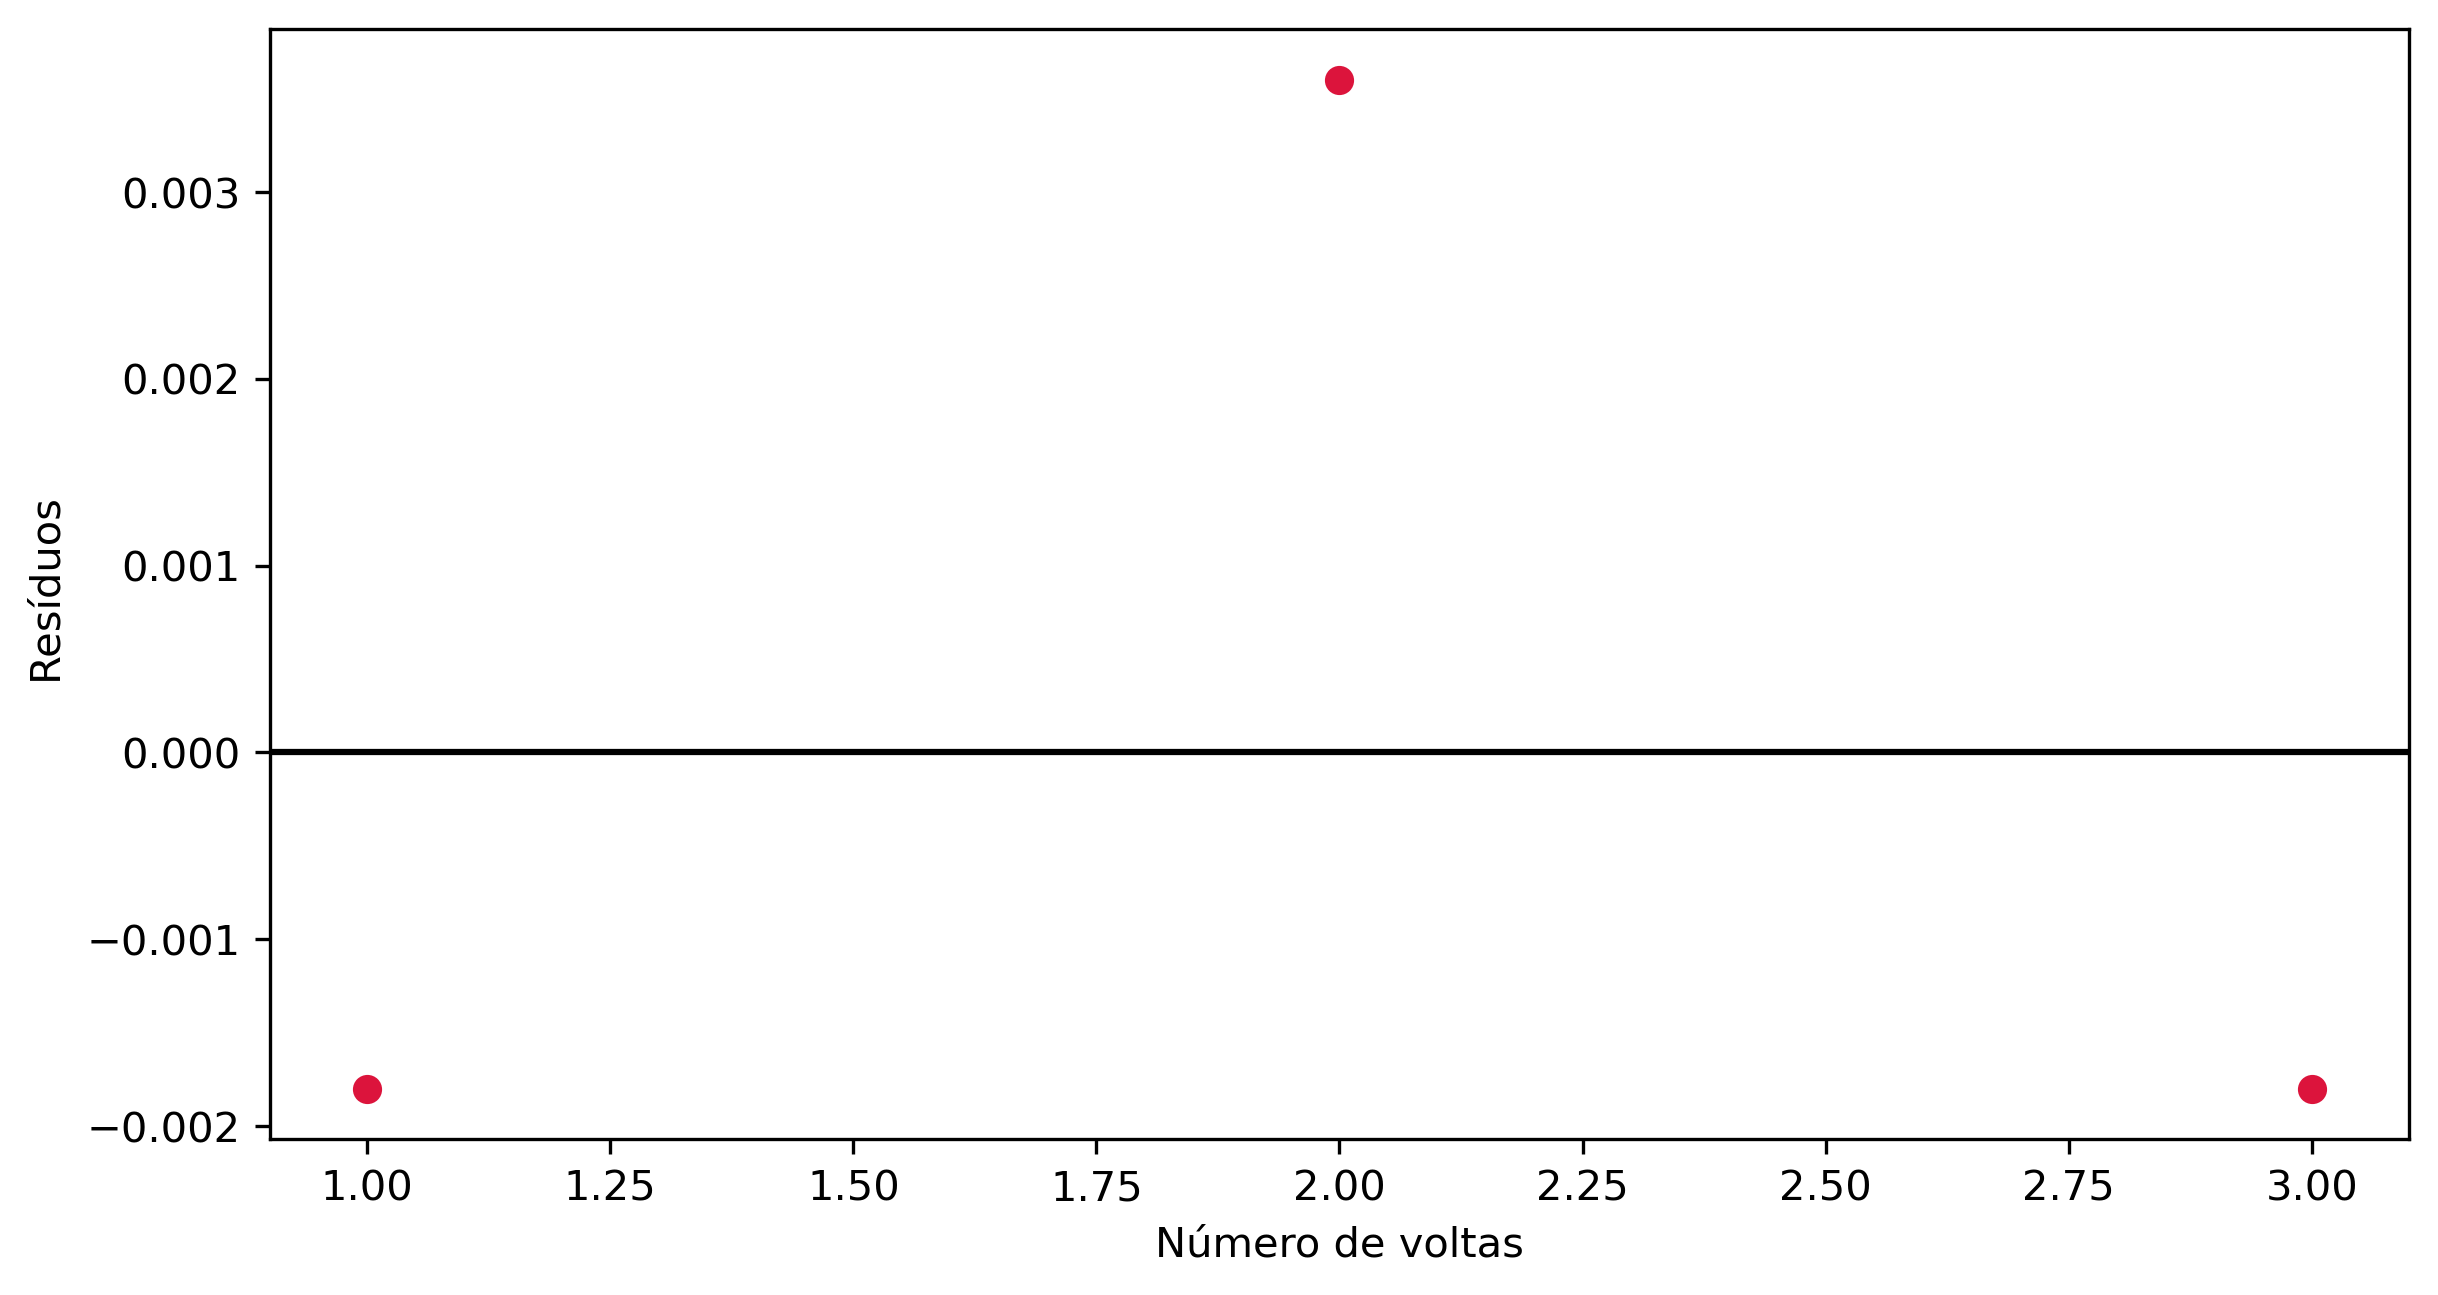

In [21]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.scatter(np.array(voltas),np.array(torque2)-np.array(voltas)*coef_angular2 - coef_linear2, color = 'crimson')
plt.axhline(y=0, color='k', linestyle='-')
plt.ylabel("Resíduos ")
plt.xlabel('Número de voltas')
plt.show()

# Parte 3: Torque magnético em função do ângulo α entre o campo magnético e o momento magnético

## Dados:

In [22]:
#Corrente fixada na espira: 2.004 A
#Corrente fixada na bobina: 2.004 A
#Usamos a espira de 3 voltas (120 mm)

#Dados:
angulo = [90,60,30,0,-30,-60,-90] # em graus
angulo = [-np.pi/2,-np.pi/3,-np.pi/6,0,np.pi/6,np.pi/3,np.pi/2] # em rad
angulo = np.array(angulo)

seno = np.sin(angulo)
print(seno)

forca_3 = [-0.90,-0.79,-0.62,-0.01,0.48,0.38,1.08] # em mN
incF3 = np.full(len(forca_3),0.05) 

[-1.        -0.8660254 -0.5        0.         0.5        0.8660254
  1.       ]


### Calculando o torque e sua incerteza

In [23]:
torque3 = 0.12*np.array(forca_3)

incT3 = 0.12*incF3

### Gráfico do dados brutos:

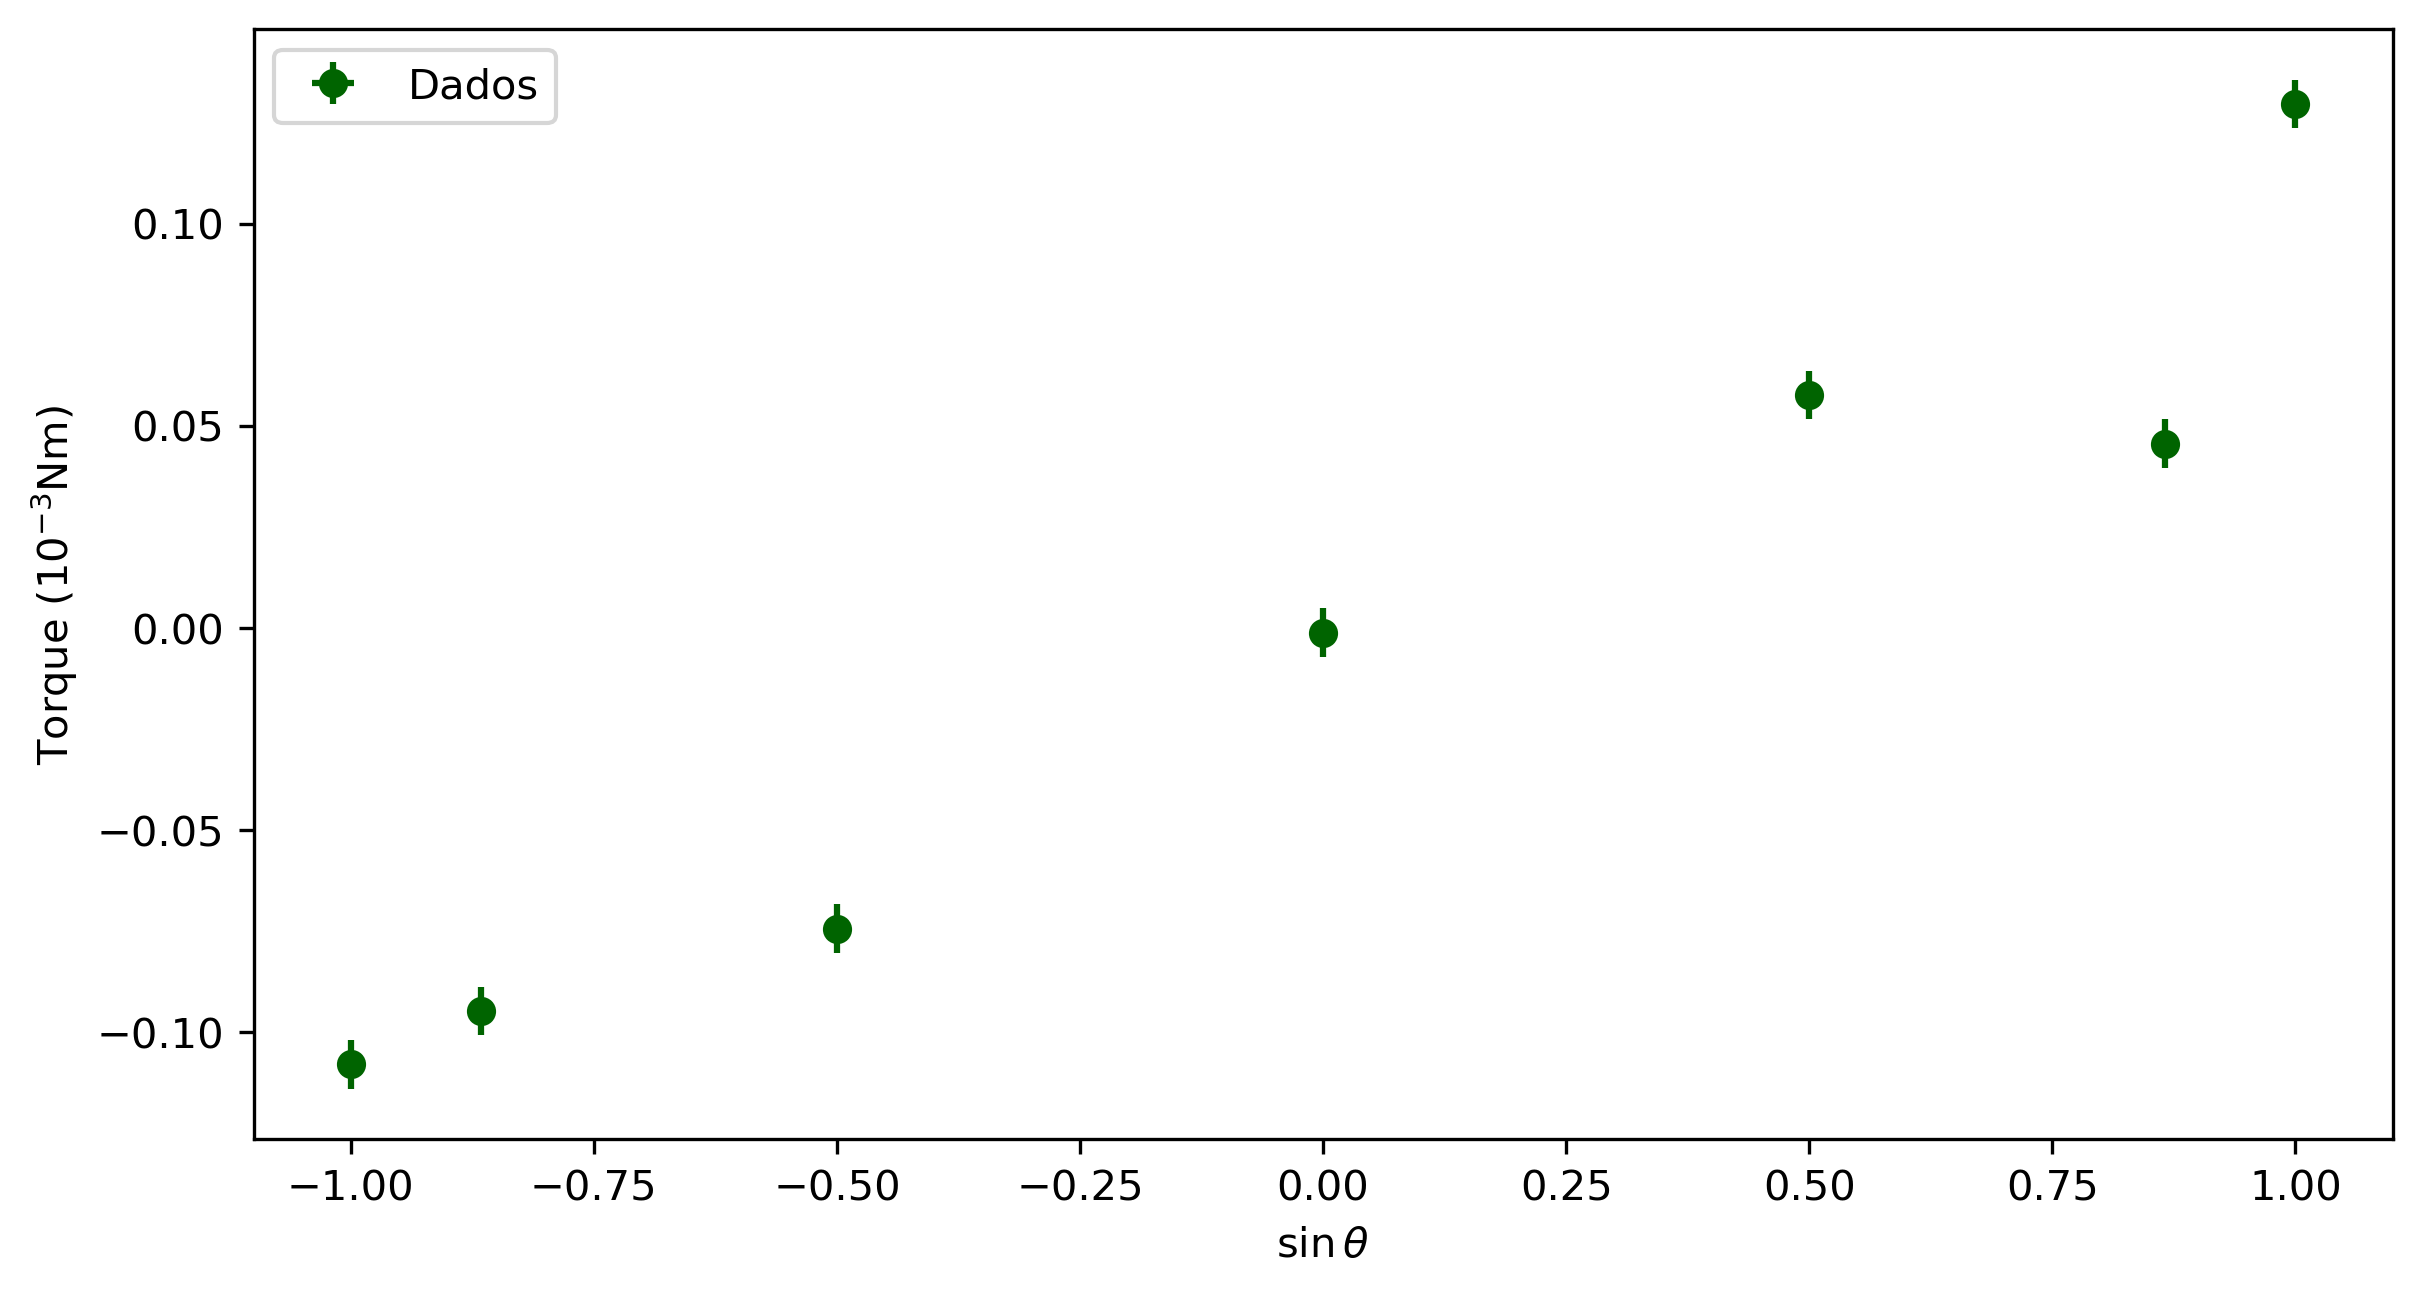

In [24]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.errorbar(seno,torque3,incT3,0, 'o', color = 'darkgreen', label = 'Dados')
plt.xlabel(r'$\sin{\theta}$ ')
plt.ylabel('Torque ($10^{-3}$Nm)')
plt.legend()
plt.show()

### Estimando a incerteza do seno do ângulo:


In [25]:
#def sin(x, a, b):
#    return a * np.sin(b * x)

In [26]:
#params, params_covariance = optimize.curve_fit(sin, angulo, seno)

In [27]:
fit3 = np.polyfit(seno,torque3 ,1)
print(fit3)

[ 0.10629749 -0.00651429]


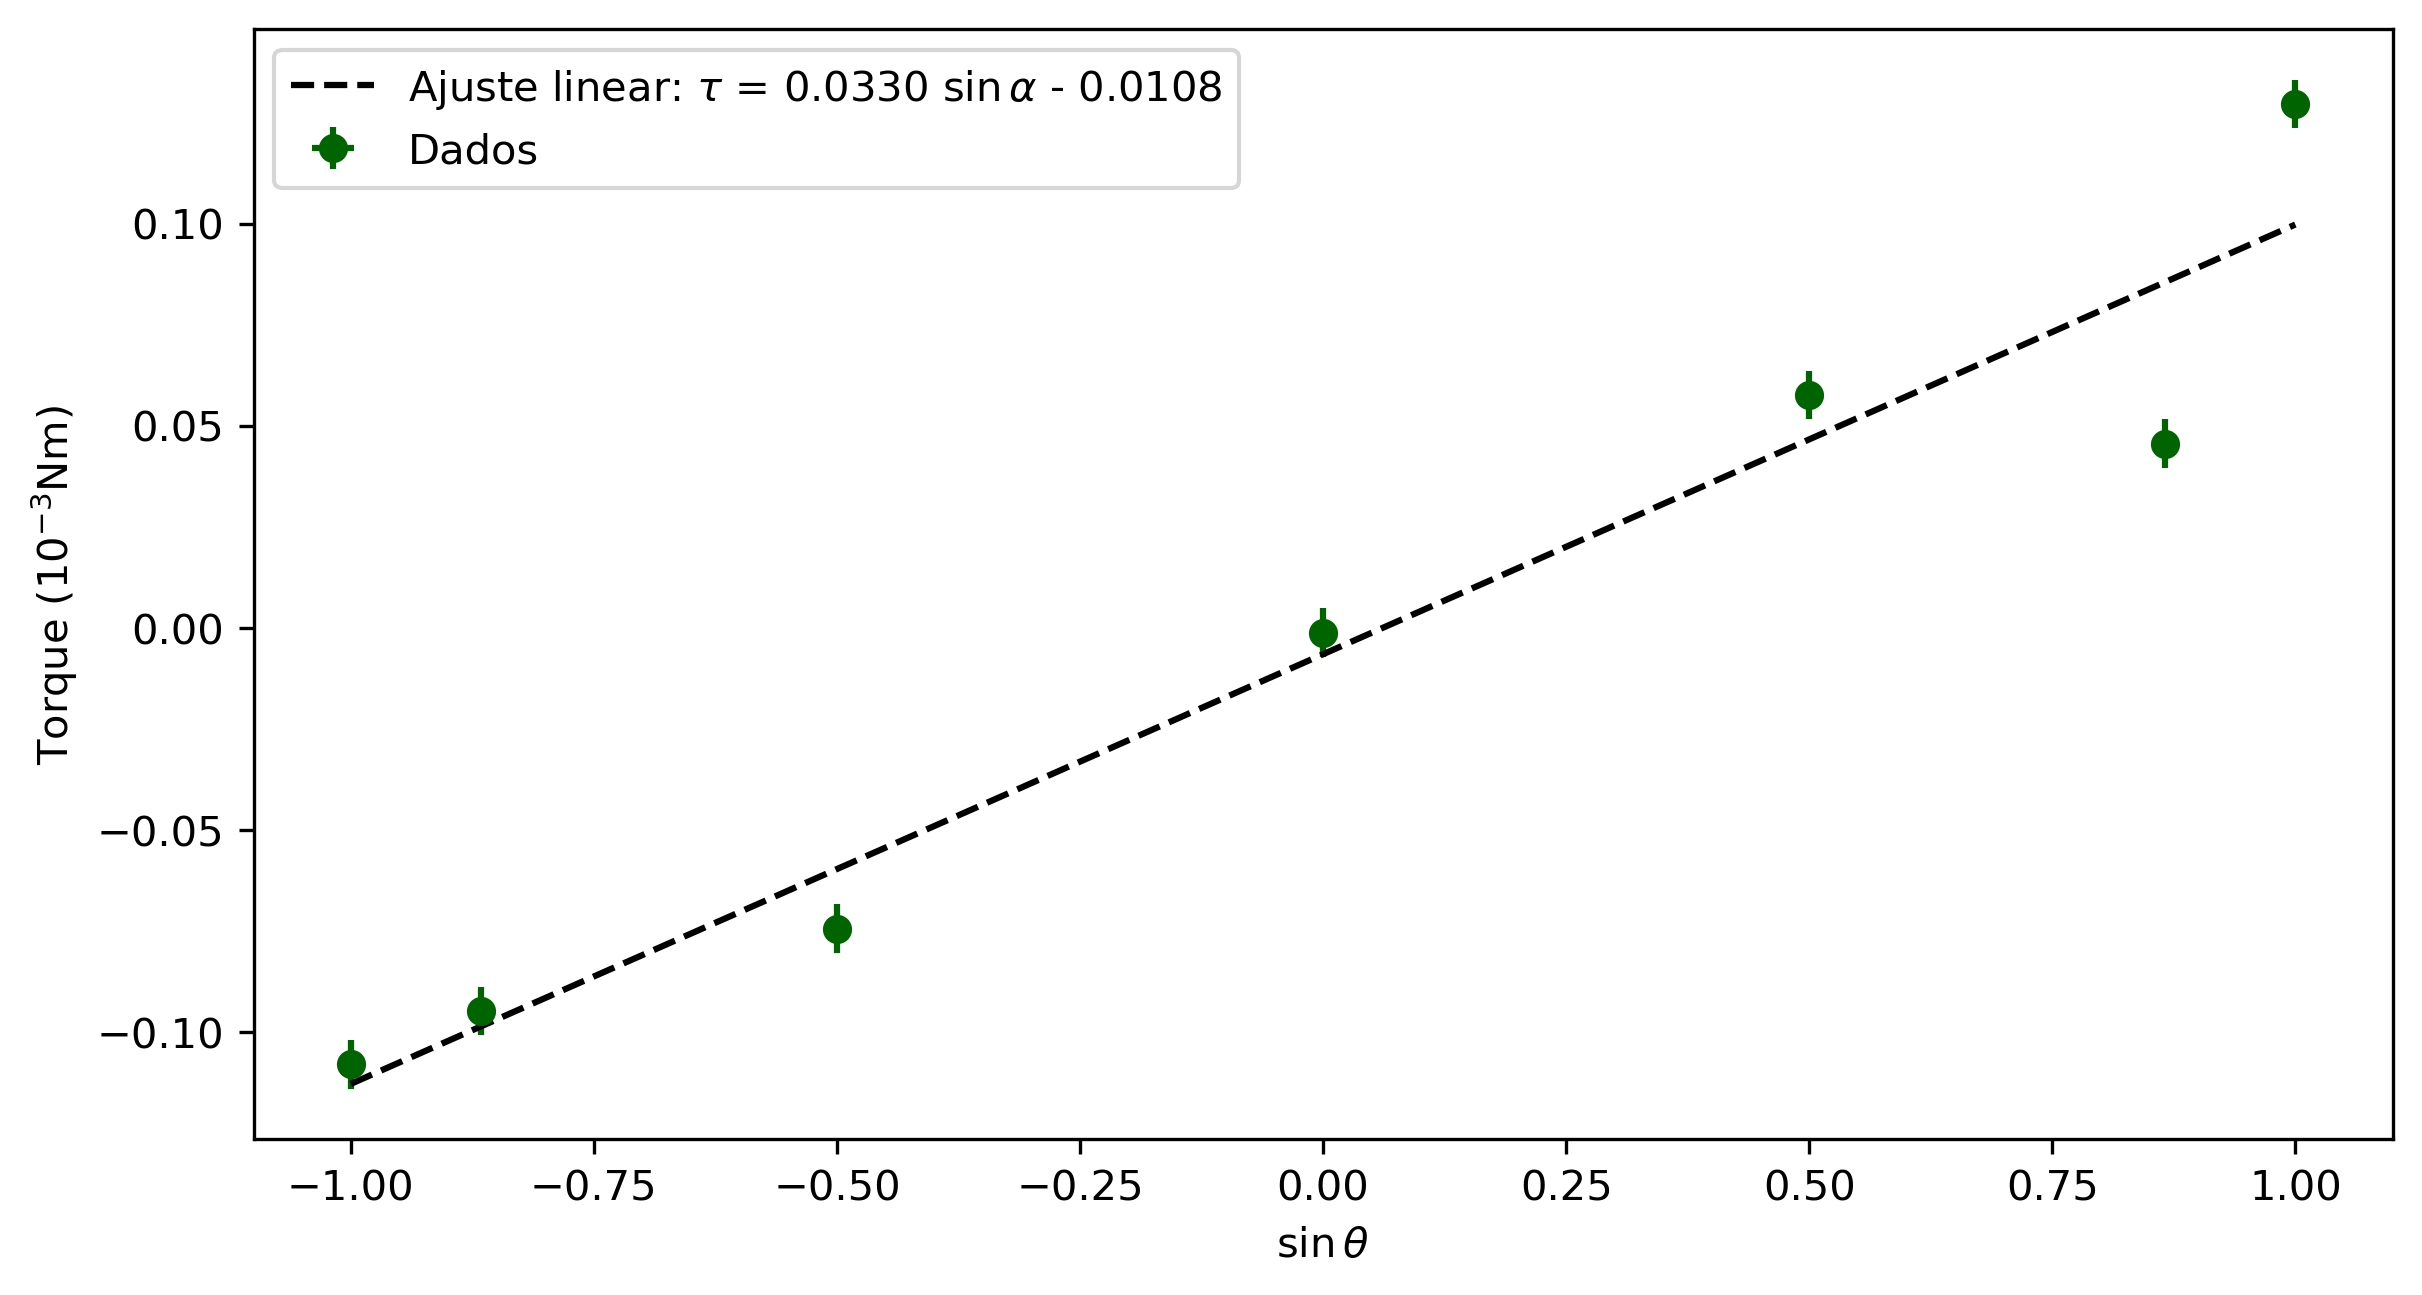

In [28]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.errorbar(seno,torque3,incT3,0, 'o', color = 'darkgreen', label = 'Dados')
plt.plot(seno,seno*fit3[0]+ fit3[1], color ='black', ls = '--', label = r'Ajuste linear: $\tau$ = %.4f $\sin{\alpha}$ - %.4f' % (coef_angular2,abs(coef_linear2)))
plt.xlabel(r'$\sin{\theta}$ ')
plt.ylabel('Torque ($10^{-3}$Nm)')
plt.legend()
plt.show()

In [29]:
# Calculando a média do módulo do desvio no eixo x para estimar a incerteza do seno
x_ajuste = (torque3 - np.full(len(torque3),fit3[1]))/(fit3[0])
desviox = abs(x_ajuste-seno)
incSenox = np.mean(desviox)
incSenox = np.full(len(seno),float('{:g}'.format(float('{:.2g}'.format(incSenox)))))
print(incSenox)

[0.15 0.15 0.15 0.15 0.15 0.15 0.15]


In [30]:
#Calulando a média do módulo da distância dos pontos y ao ajuste:
y_ajuste = np.polyval(fit3, seno)
desvio = abs(torque3 - y_ajuste)
incSeno = np.mean(desvio)/fit3[0]
incSeno = np.full(len(seno),float('{:g}'.format(float('{:.2g}'.format(incSeno)))))
print(incSeno)

[0.15 0.15 0.15 0.15 0.15 0.15 0.15]


### Transferência de incertezas:

O modelo teórico é $\tau = c \ I_e \ I_b \ n \ A \ sin{\alpha}$

$$\sigma_\tau = \sqrt{\sigma_{\tau \ 0}^2 + \bigg(\frac{\partial \tau}{\partial \sin{\alpha}}\bigg)^2\sigma^2_{\sin{\alpha}} +  \bigg(\frac{\partial \tau}{\partial I_b}\bigg)^2\sigma^2_{I_b} +\bigg(\frac{\partial \tau}{\partial I_e}\bigg)^2\sigma^2_{I_e} }$$
$$\sigma_\tau = \sqrt{\sigma_{\tau \ 0}^2 + \bigg(\frac{\partial \tau}{\partial \sin{\alpha}}\bigg)^2\sigma^2_{\sin{\alpha}} + \bigg(\frac{\partial c \ I_e \ I_b \ n \ A \ \sin{\alpha}}{\partial I_b}\bigg)^2\sigma^2_{I_b} +\bigg(\frac{\partial c \ I_e \ I_b \ n \ A \ \sin{\alpha}}{\partial I_e}\bigg)^2\sigma^2_{I_e} }$$
$$\sigma_\tau = \sqrt{\sigma_{\tau \ 0}^2 +  \bigg(\frac{\partial \tau}{\partial \sin{\alpha}}\bigg)^2\sigma^2_{\sin{\alpha}}+\bigg(c \ I_e  \ n \ A \ \sin{\alpha}\bigg)^2\sigma^2_{I_b} +\bigg( c  \ I_b \ n \ A \ \sin{\alpha}\bigg)^2\sigma^2_{I_e} }$$

In [31]:

i_esp = i_bob = 2.004 #A
incI = 0.01*i_esp + 2*0.001 #A



inctransf_T3 = np.sqrt(np.power(incT3,2) + np.power(fit3[0]*np.array(incSenox),2) + np.power(n*c*area*i_esp*seno*incI,2) + np.power(n*c*area*i_bob*seno*incI,2))

inctransf_T3 = [float('{:g}'.format(float('{:.2g}'.format(i)))) for i in inctransf_T3]
print(inctransf_T3)

[0.017, 0.017, 0.017, 0.017, 0.017, 0.017, 0.017]


### Ajuste através do MMQ

In [32]:
fitpars3, cov_pars3 = np.polyfit(seno,torque3,1,w=np.power(inctransf_T3,-1),cov='True')

coef_angular3 = fitpars3[0]
coef_linear3 = fitpars3[1]
sigma_angular3 = np.sqrt(cov_pars3[0][0])
sigma_linear3 = np.sqrt(cov_pars3[1][1])

sigma_angular3 = float('{:g}'.format(float('{:.2g}'.format(sigma_angular3))))
sigma_linear3 = float('{:g}'.format(float('{:.2g}'.format(sigma_linear3))))

                     
print('Coeficiente angular: %.3f +- %.3f (10^{-3}Nm)' % (coef_angular3 ,sigma_angular3))
print('Coeficiente linear: %.4f +- %.4f (10^{-3}Nm)' %(coef_linear3,sigma_linear3))

Coeficiente angular: 0.106 +- 0.012 (10^{-3}Nm)
Coeficiente linear: -0.0065 +- 0.0091 (10^{-3}Nm)


In [33]:
print(i_esp*i_bob*c*n*area)

9.43419029926745e-05


### Gráfico do ajuste

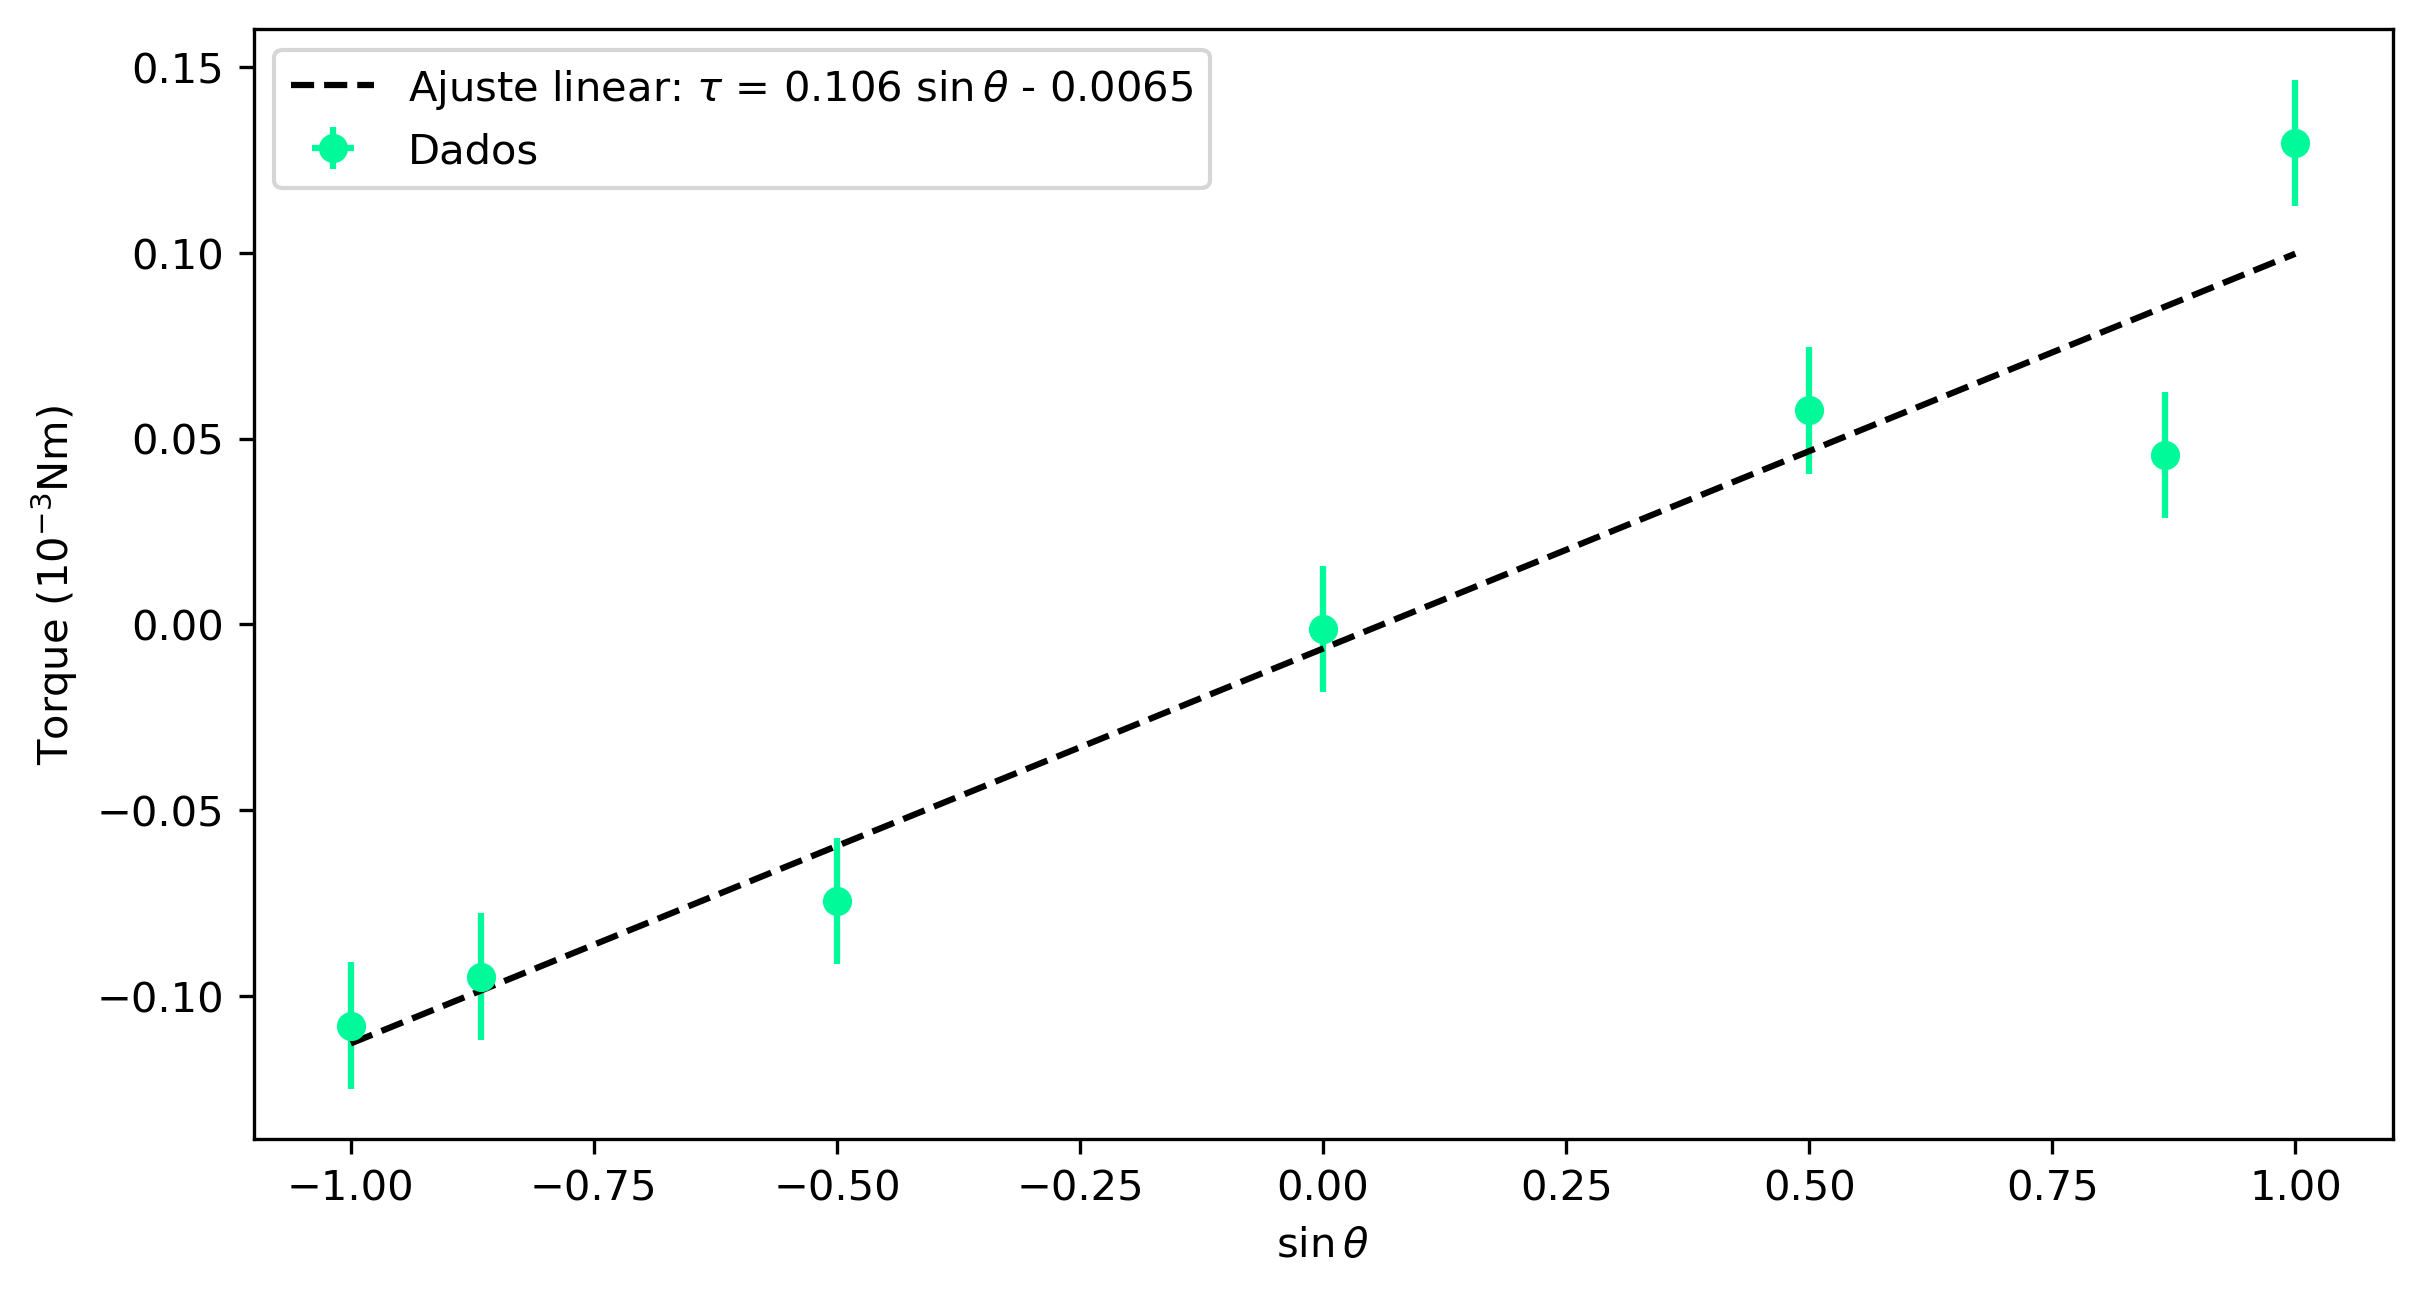

In [34]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.errorbar(seno,torque3,inctransf_T3,0, 'o', color = 'Mediumspringgreen', label = 'Dados')
plt.plot(seno,np.array(seno)*coef_angular3 + coef_linear3, color ='black', ls = '--', label = r'Ajuste linear: $\tau$ = %.3f $\sin{\theta}$ - %.4f' % (coef_angular3,abs(coef_linear3)))
plt.xlabel(r'$\sin{\theta}$ ')
plt.ylabel('Torque ($10^{-3}$Nm)')
plt.legend()
plt.show()

### Qualidade do ajuste:

In [35]:
#Calulando chi^2_red
yhat3 = np.polyval(fitpars3, seno)
chi_squared3 = np.sum(((yhat3 - torque3)/inctransf_T3) ** 2)
chi2_red3 = chi_squared3/(len(seno)-2)

#Imprimindo o resultado
print("chi^2_red = %.3f" % chi2_red3)

chi^2_red = 1.998


### Gráfico de resíduos

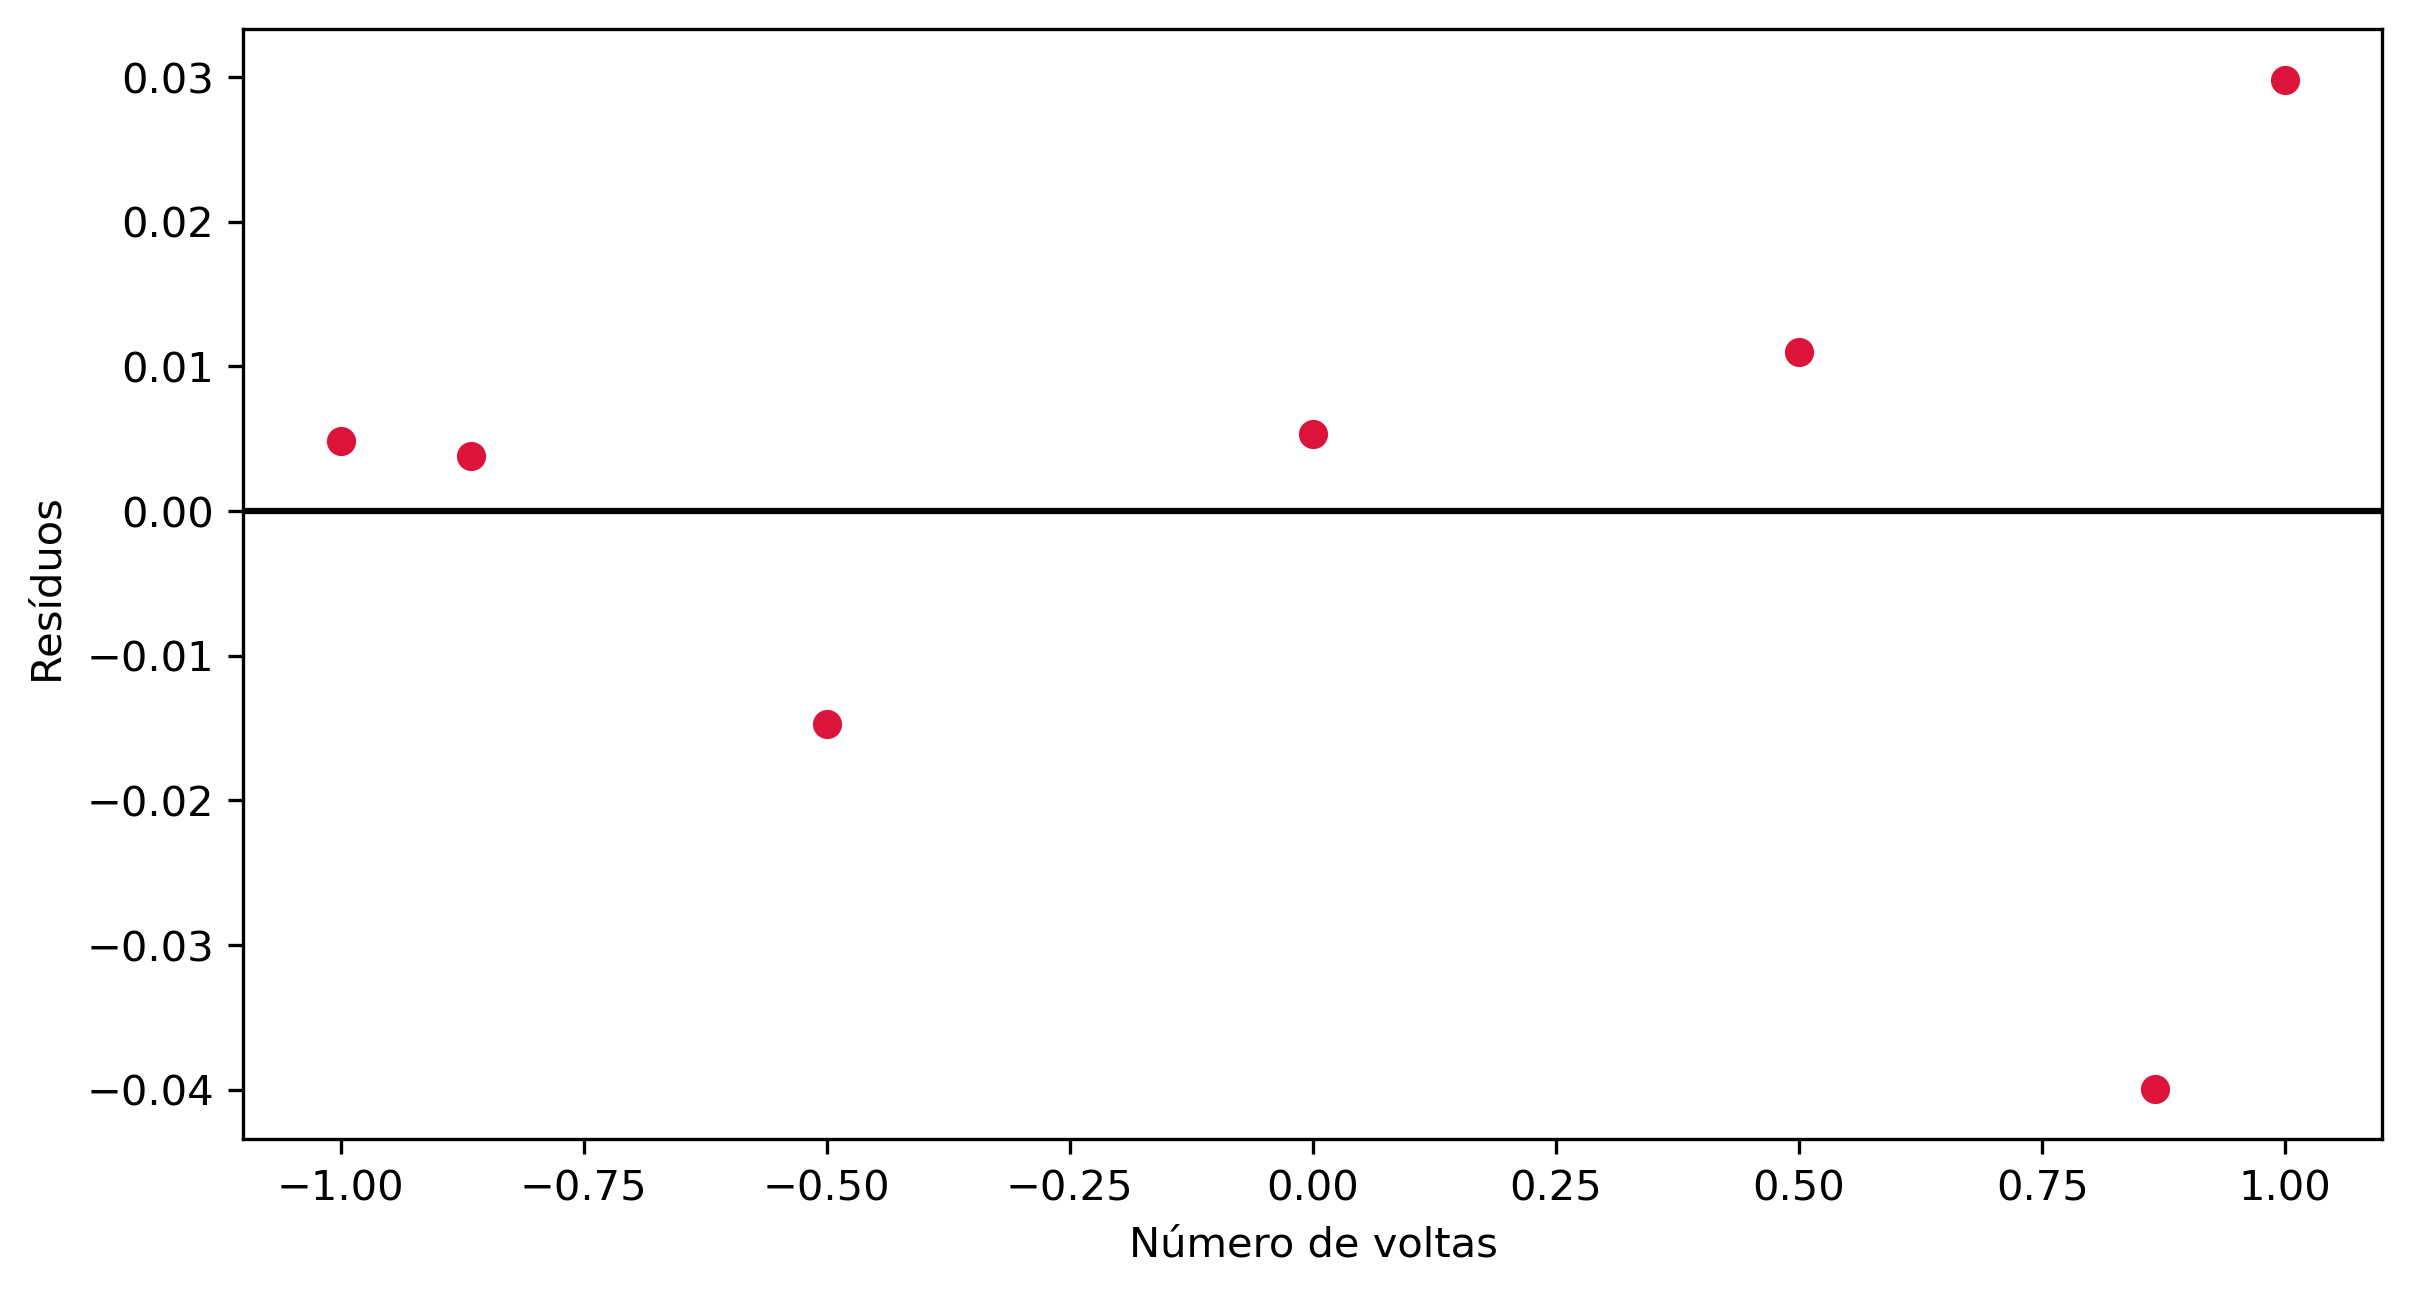

In [36]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.scatter(np.array(seno),np.array(torque3)-np.array(seno)*coef_angular3 - coef_linear3, color = 'crimson')
plt.axhline(y=0, color='k', linestyle='-')
plt.ylabel("Resíduos ")
plt.xlabel('Número de voltas')
plt.show()

# Parte 4: Torque magnético em função do diâmetro da espira

## Dados:

In [37]:
#Corrente fixada na espira: 2.003 A
#Corrente fixada na bobina: 2.002 A

#Dados:
forca_4 = [0.35,0.15,0.08] # em mN
forca_4 = np.array(forca_4)
incF4 = np.full(len(forca_4),0.05)#mN

diametro= [120,85,60] # em mm
diametro = np.array(diametro)/1000 #m
incD = np.full(len(diametro),5e-4)

d2 = np.power(diametro,2)
incD2 = np.multiply(2*diametro,incD)
#incdiametro = np.full(len(diametro), ???)

### Calculando o torque e sua incerteza:


In [38]:
torque4 = 0.12*forca_4

incT4 = 0.12*incF4

### Gráfico dos dados brutos:

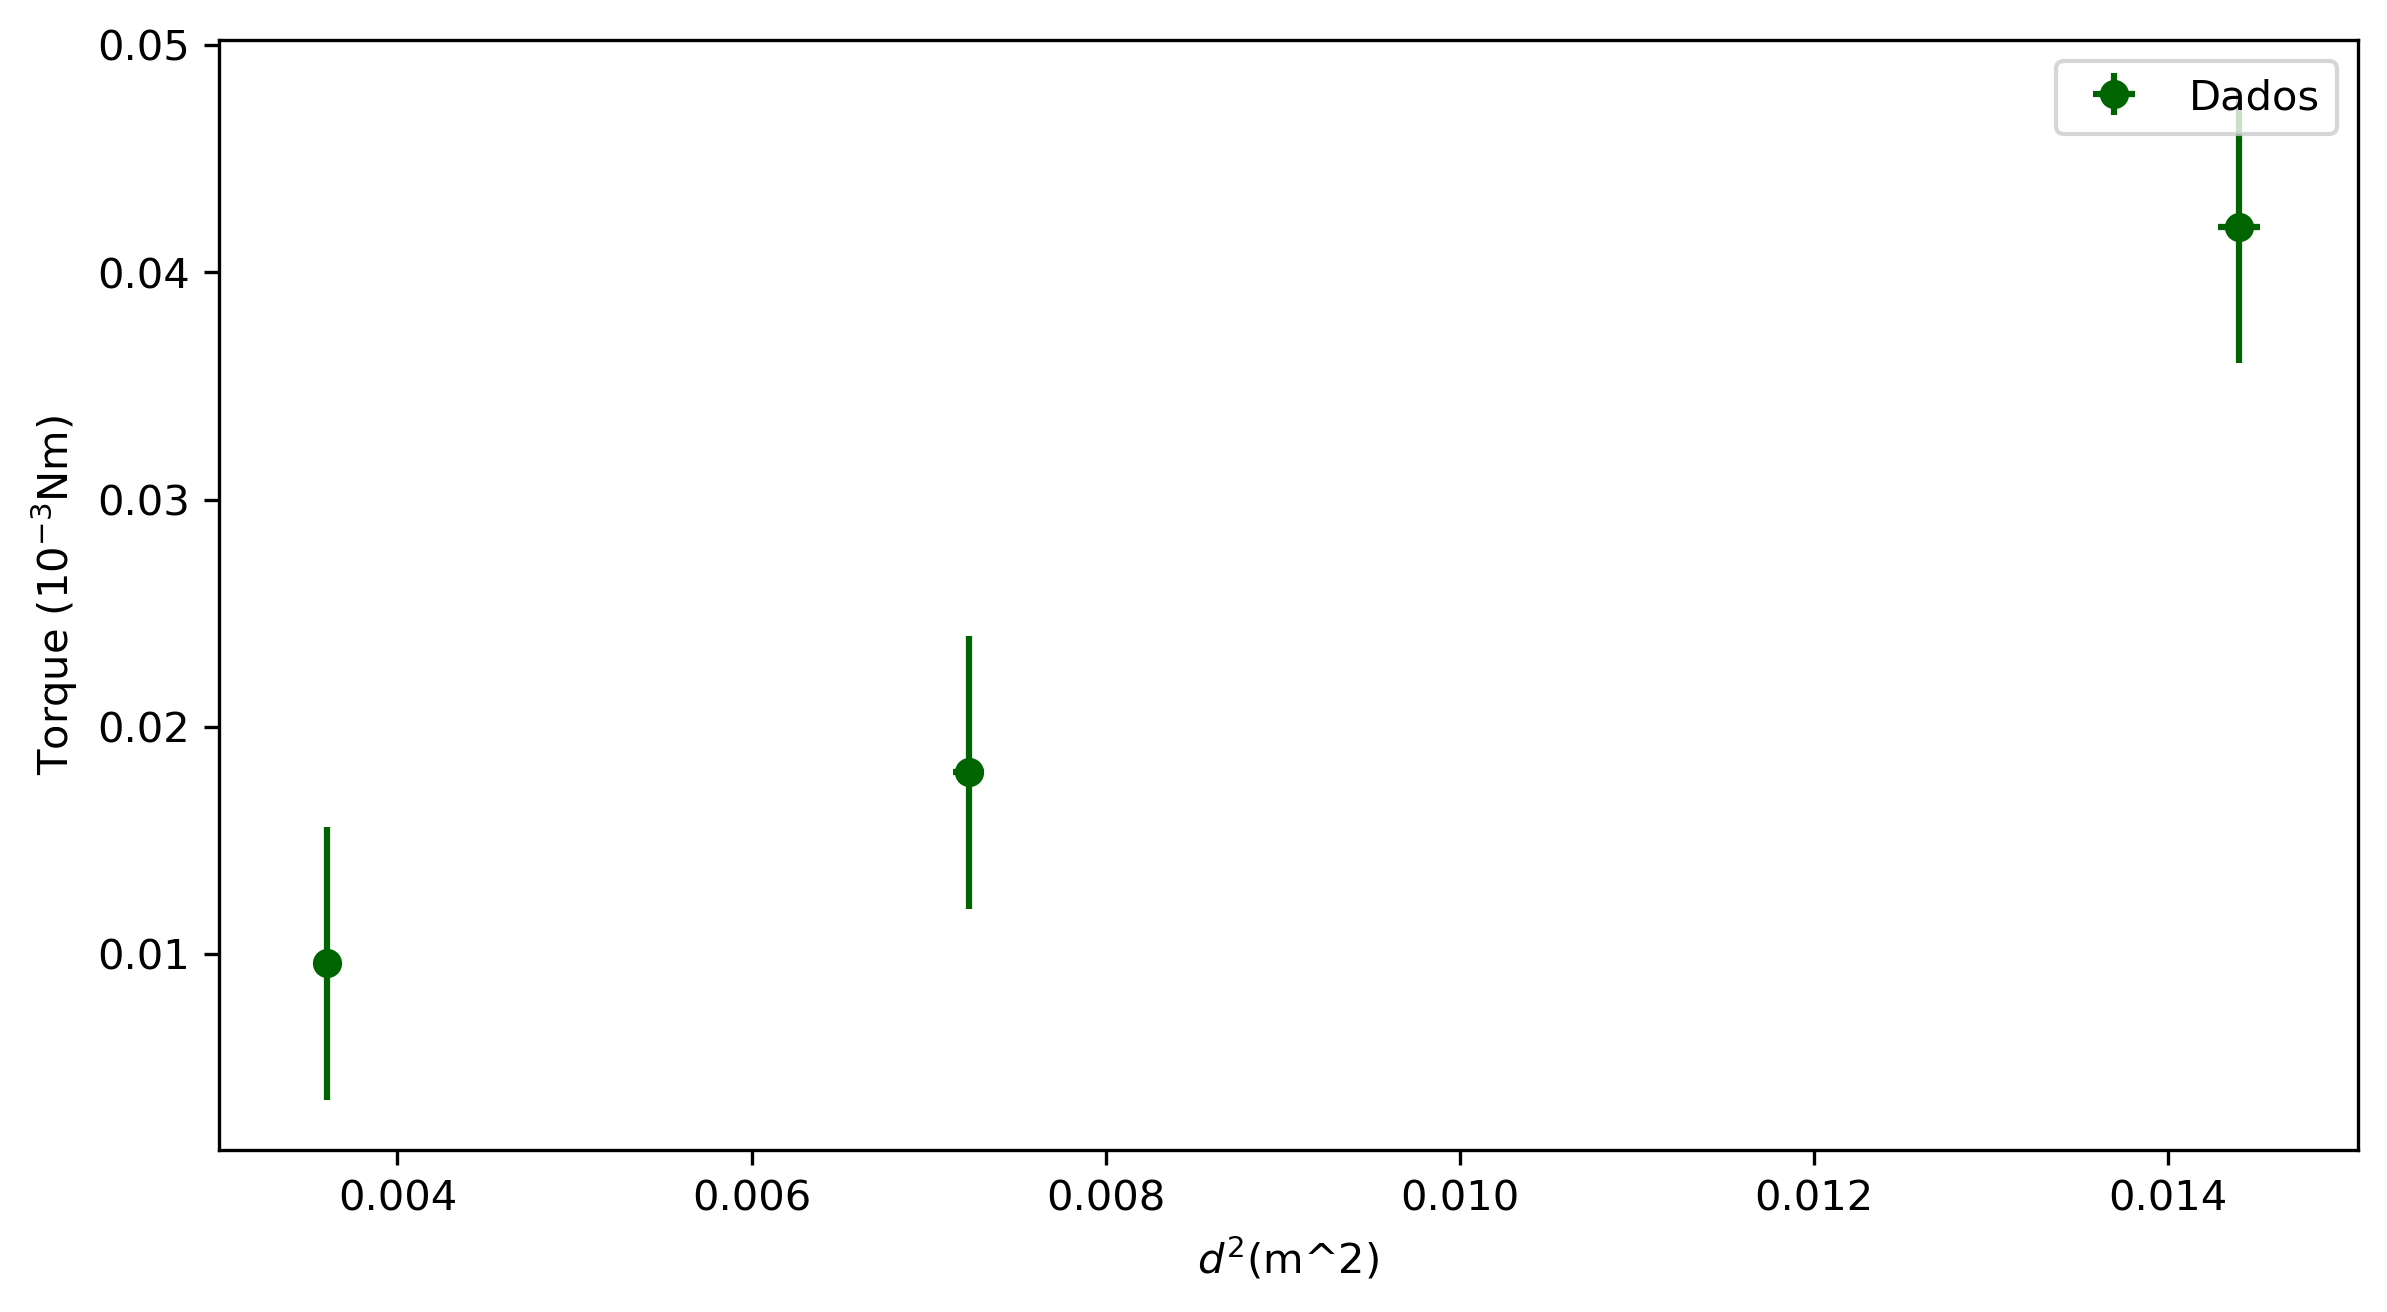

In [39]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.errorbar(d2,torque4,incT4,incD2, 'o', color = 'darkgreen', label = 'Dados')
plt.xlabel(r'$d^2 ($m^2$)$')
plt.ylabel('Torque ($10^{-3}$Nm)')
plt.legend()
plt.show()

### Trasnferência de incertezas:


O modelo teórico é $\tau = c \ I_e \ I_b \ n \ A$

$$\sigma_\tau = \sqrt{\sigma_{\tau \ 0}^2 + \bigg(\frac{\partial \tau}{\partial I_b}\bigg)^2\sigma^2_{I_b} +\bigg(\frac{\partial \tau}{\partial I_e}\bigg)^2\sigma^2_{I_e} }$$
$$\sigma_\tau = \sqrt{\sigma_{\tau \ 0}^2 + \bigg(\frac{\partial c \ I_e \ I_b \ n \ A}{\partial I_b}\bigg)^2\sigma^2_{I_b} +\bigg(\frac{\partial c \ I_e \ I_b \ n \ A}{\partial I_e}\bigg)^2\sigma^2_{I_e} }$$
$$\sigma_\tau = \sqrt{\sigma_{\tau \ 0}^2 + \bigg(c \ I_e  \ n \ A\bigg)^2\sigma^2_{I_b} +\bigg( c  \ I_b \ n \ A\bigg)^2\sigma^2_{I_e} }$$


In [40]:

i_es = 2.003 #A
incIES = 0.01*i_es + 2*0.001 #A
i_b = 2.002 #A
incIB = 0.01*i_b + 2*0.001 #A

fit4 = np.polyfit(d2, torque4,1)

a = np.pi*np.power(diametro,2)/4

inctransf_T4 = np.sqrt(np.power(incT4,2)+ np.power(fit4[0]*np.array(incD2),2)  + np.power(3*c*a*i_b*incIES,2) + np.power(3*c*a*i_es*incIB,2) )

inctransf_T4 = [float('{:g}'.format(float('{:.2g}'.format(i)))) for i in inctransf_T4]
print(inctransf_T4)

[0.006, 0.006, 0.006]


### Ajuste através do MMQ

In [41]:
fitpars4, cov_pars4 = np.polyfit(d2,torque4,1,w=np.power(inctransf_T4,-1),cov='True')

coef_angular4 = fitpars4[0]
coef_linear4 = fitpars4[1]
sigma_angular4 = np.sqrt(cov_pars4[0][0])
sigma_linear4 = np.sqrt(cov_pars4[1][1])

sigma_angular4 = float('{:g}'.format(float('{:.2g}'.format(sigma_angular4))))
sigma_linear4 = float('{:g}'.format(float('{:.2g}'.format(sigma_linear4))))

                     
print('Coeficiente angular: %.2f +- %.2f (10^{-3}Nm)' % (coef_angular4 ,sigma_angular4))
print('Coeficiente linear: %.4f +- %.4f (10^{-3}Nm)' %(coef_linear4,sigma_linear4))

Coeficiente angular: 3.05 +- 0.26 (10^{-3}Nm)
Coeficiente linear: -0.0024 +- 0.0024 (10^{-3}Nm)


### Gráfico do ajuste:

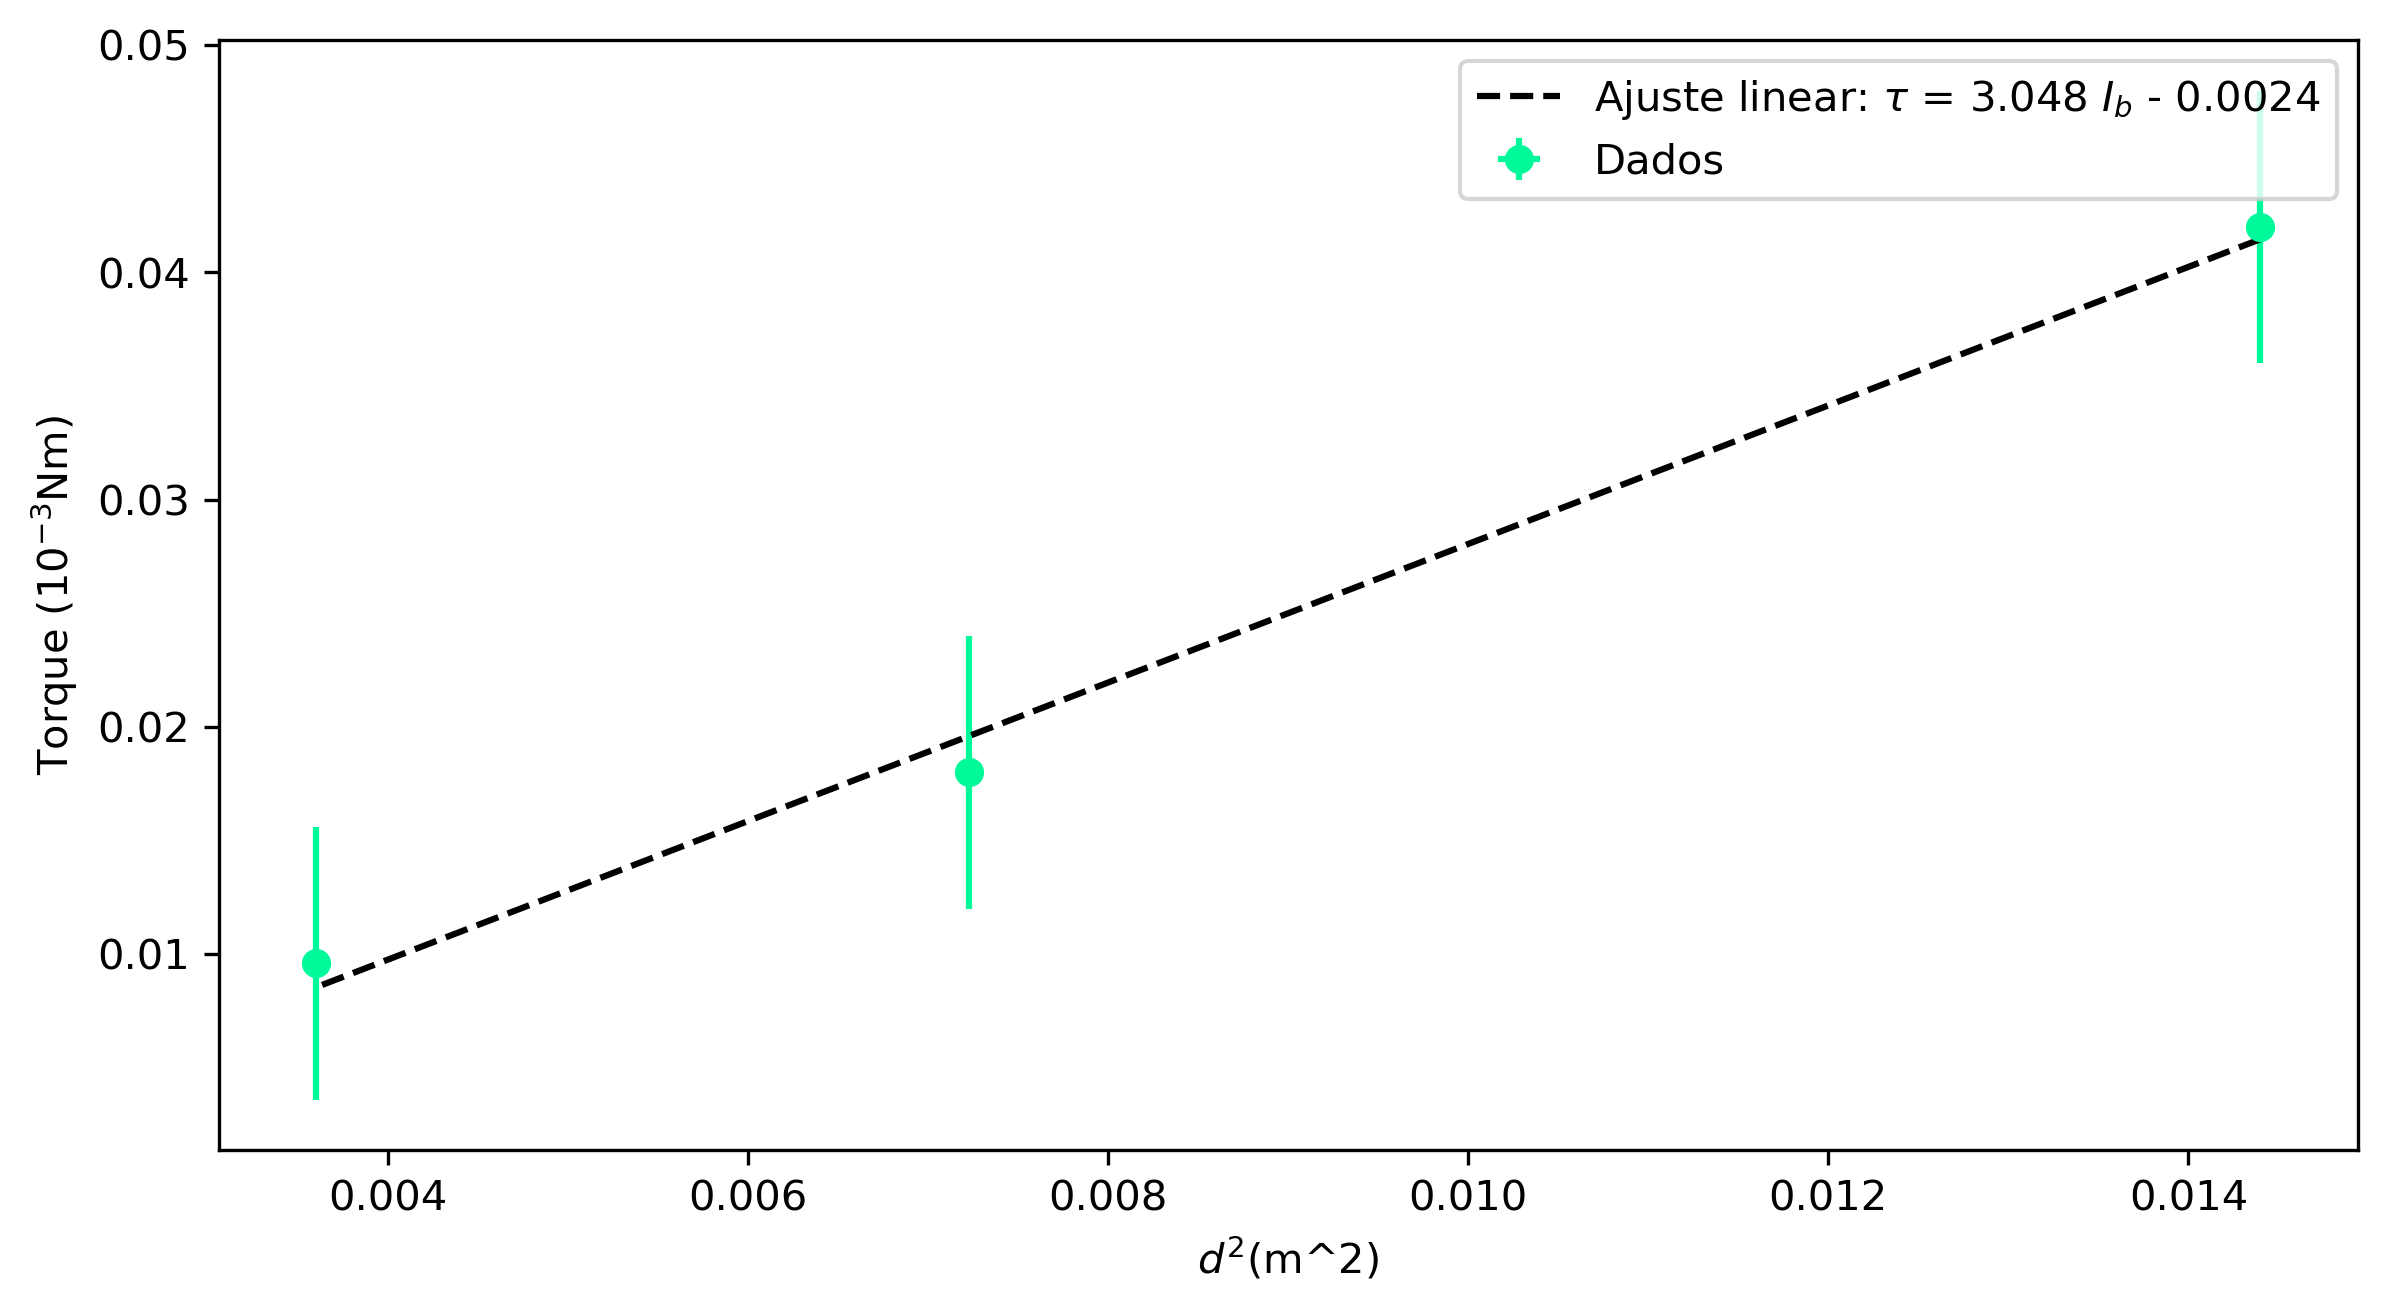

In [42]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.errorbar(d2,torque4,inctransf_T4,0, 'o', color = 'Mediumspringgreen', label = 'Dados')
plt.plot(d2,np.array(d2)*coef_angular4 + coef_linear4, color ='black', ls = '--', label = r'Ajuste linear: $\tau$ = %.3f $I_{b}$ - %.4f' % (coef_angular4,abs(coef_linear4)))
plt.xlabel(r'$d^2 ($m^2$)$')
plt.ylabel('Torque ($10^{-3}$Nm)')
plt.legend()
plt.show()

### Qualidade do ajuste:

In [43]:
#Calulando chi^2_red
yhat4 = np.polyval(fitpars4, d2)
chi_squared4 = np.sum(((yhat4 - torque4)/inctransf_T4) ** 2)
chi2_red4 = chi_squared4/(len(d2)-2)

#Imprimindo o resultado
print("chi^2_red = %.3f" % chi2_red4)

chi^2_red = 0.109


### Gráfico de resíduos:

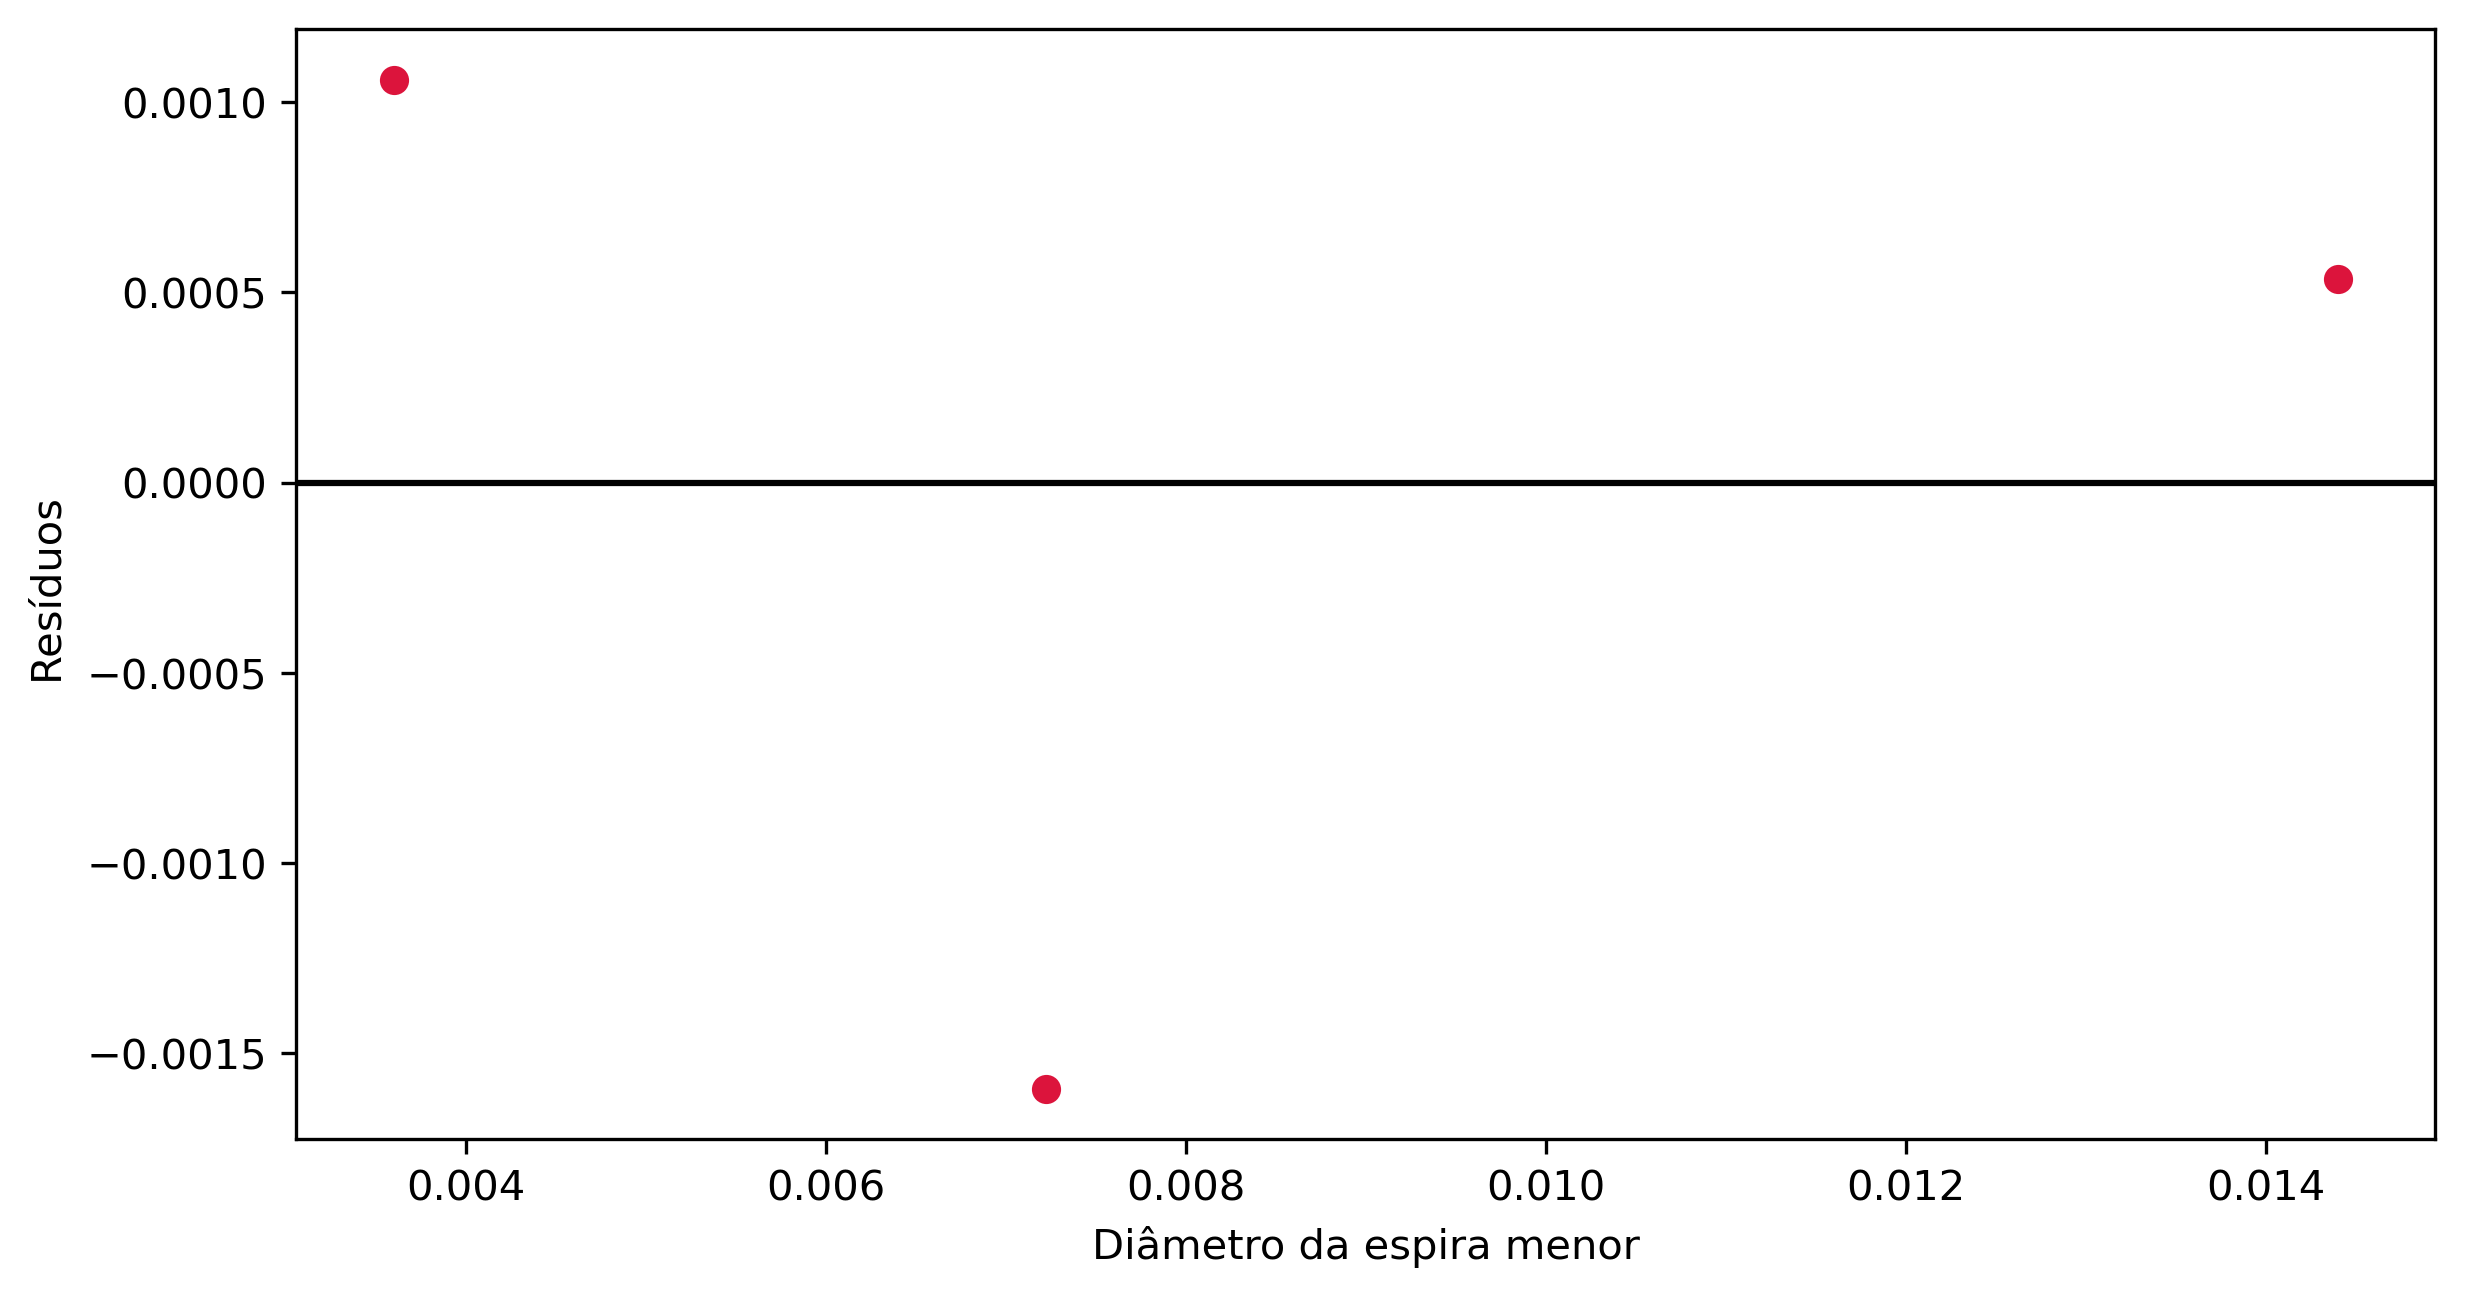

In [44]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.scatter(d2,np.array(torque4)-np.array(d2)*coef_angular4 - coef_linear4, color = 'crimson')
plt.axhline(y=0, color='k', linestyle='-')
plt.ylabel("Resíduos ")
plt.xlabel('Diâmetro da espira menor')

plt.show()

# Parte 5: Torque magnético em função da corrente na espira

## Dados:

In [45]:
#Corrente fixada na bobina: 2.003 A

#Dados:
i_espira = [0.255,0.500,0.760,1.028,1.253,1.497,1.753,2.010,2.249,2.506] # em A
i_espira = np.array(i_espira)

forca_5= [0.11,0.20,0.38,0.50,0.60,0.74,0.87,0.98,1.17,1.30] # em mN
forca_5 = np.array(forca_5)
incF5 = np.full(len(forca_5),0.05) #mN

### Incerteza da corrente na espira:

$(1.0\%+2D)$

In [46]:
incI_espira = [float('{:g}'.format(float('{:.2g}'.format(i*0.01 + 2*0.001)))) for i in i_espira] #A

### Calculando o torque e sua incerteza

In [47]:
torque5 = 0.12*forca_5 #10^{-3}Nm

incT5 = 0.12*incF5 #10^{-3}Nm

### Gráfico dos dados brutos:

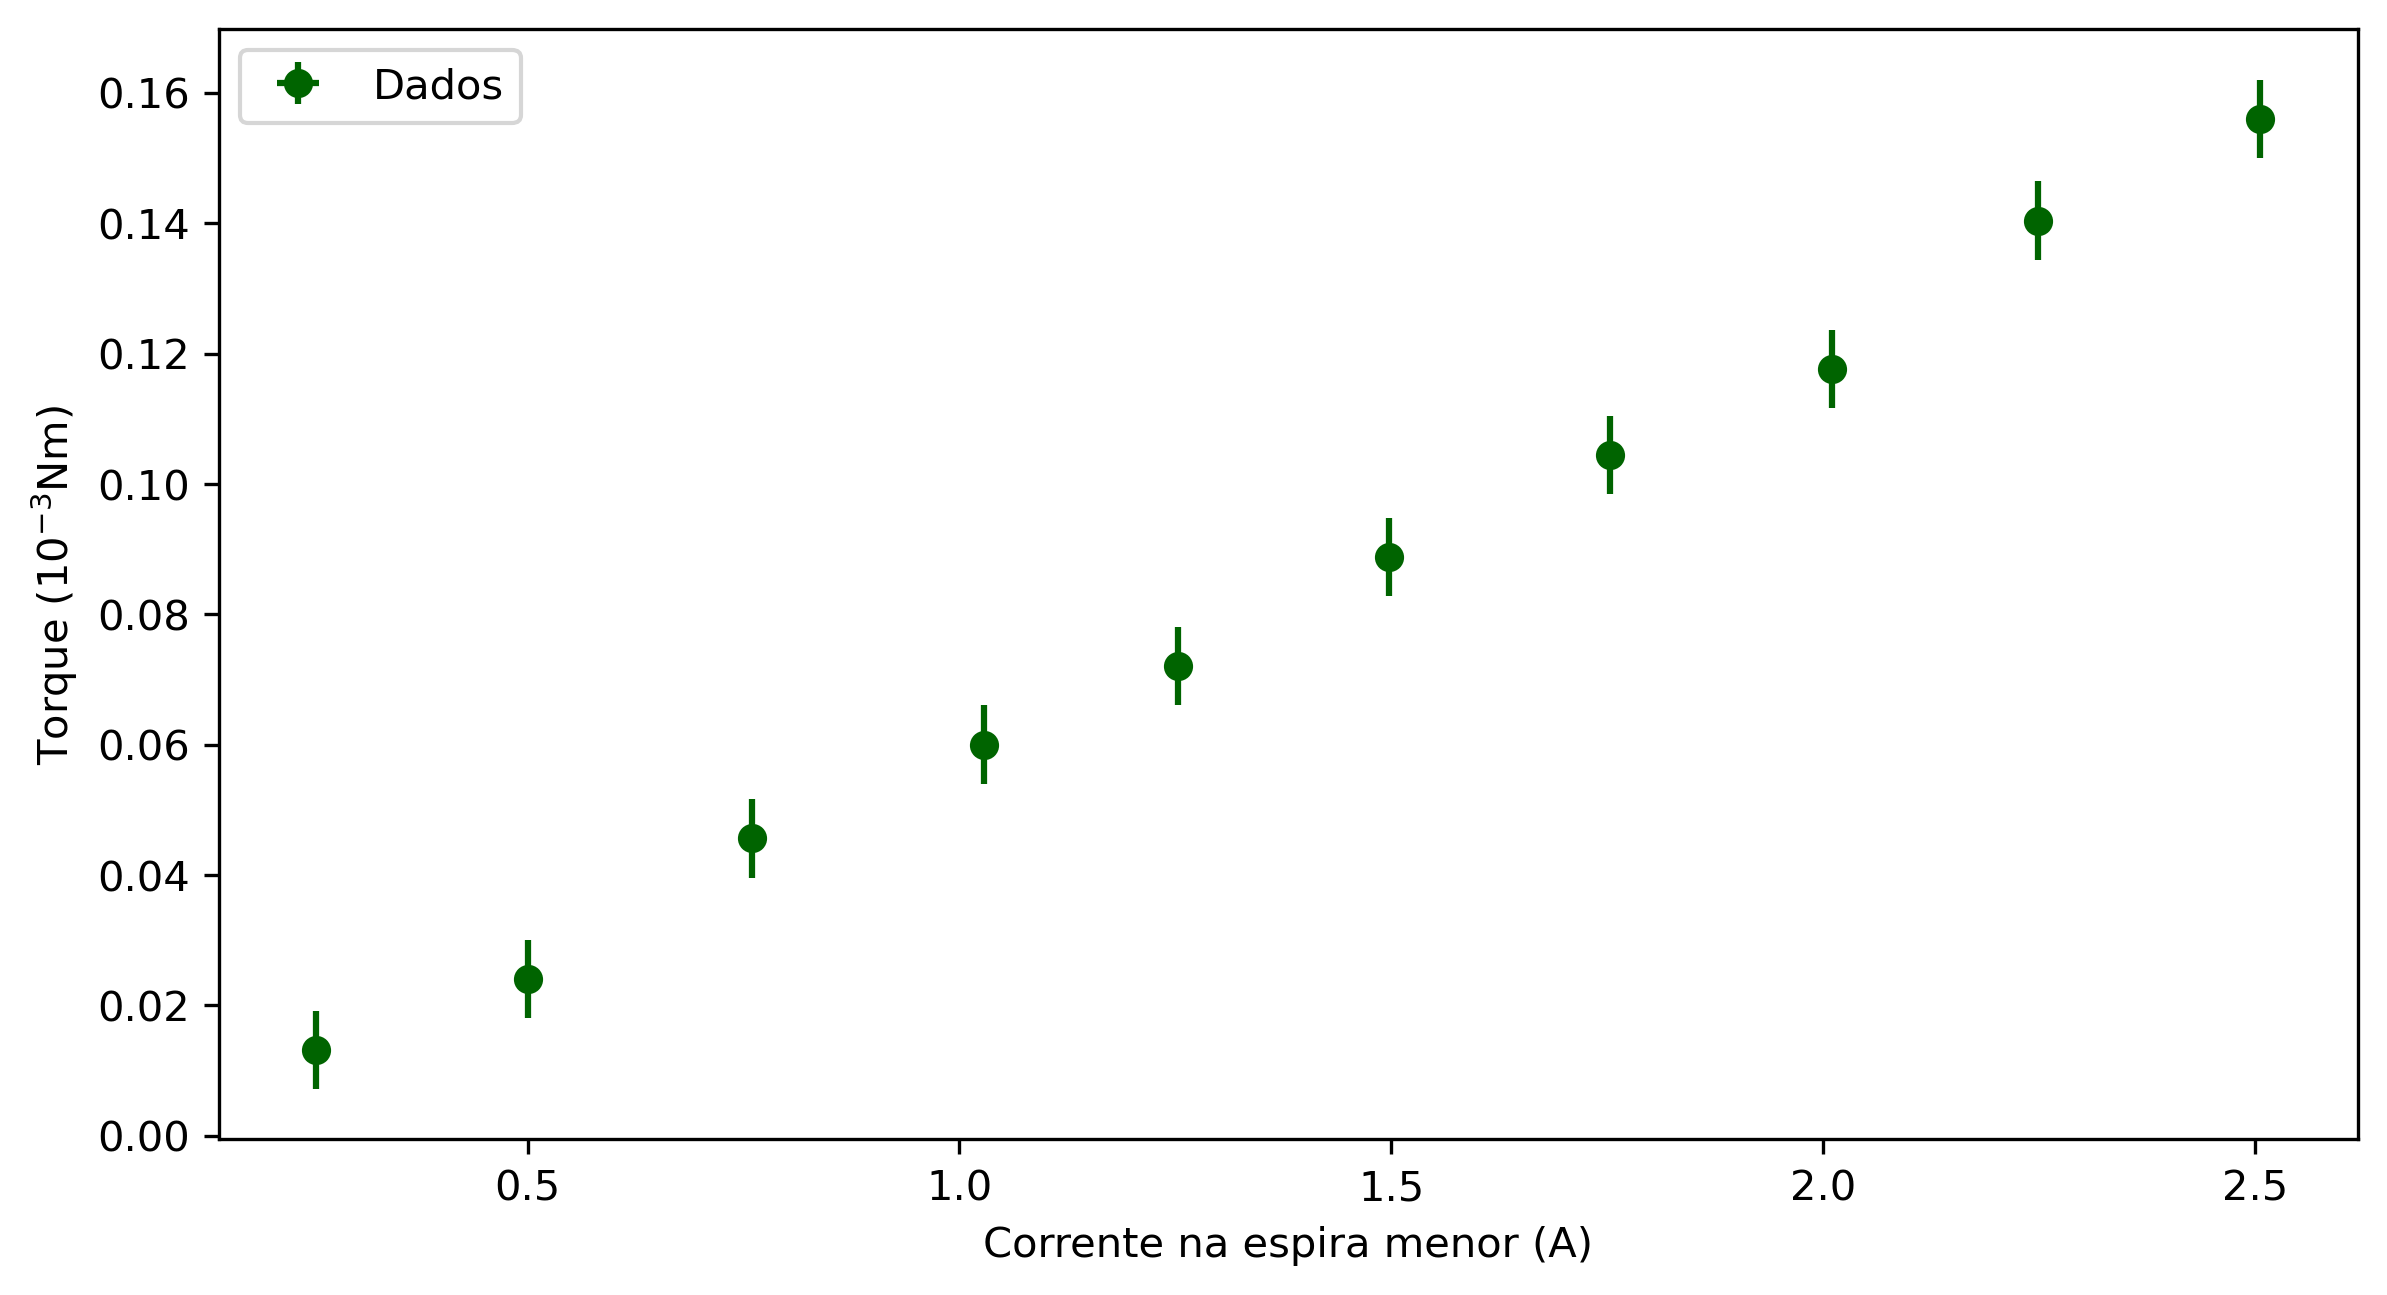

In [48]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.errorbar(i_espira,torque5,incT5,0, 'o', color = 'darkgreen', label = 'Dados')
plt.xlabel('Corrente na espira menor (A)')
plt.ylabel('Torque ($10^{-3}$Nm)')
plt.legend()
plt.show()

### Transferência de incerteza:


O modelo teórico é $\tau = c \ I_e \ I_b \ n \ A$

$$\sigma_\tau = \sqrt{\sigma_{\tau \ 0}^2 + \bigg(\frac{\partial \tau}{\partial I_e}\bigg)^2\sigma^2_{I_e} +\bigg(\frac{\partial \tau}{\partial I_b}\bigg)^2\sigma^2_{I_b} }$$
$$\sigma_\tau = \sqrt{\sigma_{\tau \ 0}^2 + \bigg(\frac{\partial \tau}{\partial I_e}\bigg)^2\sigma^2_{I_e} +\bigg(\frac{\partial c \ I_e \ I_b \ n \ A}{\partial I_b}\bigg)^2\sigma^2_{I_b} }$$
$$\sigma_\tau = \sqrt{\sigma_{\tau \ 0}^2 + \bigg(\frac{\partial \tau}{\partial I_e}\bigg)^2\sigma^2_{I_e} +\bigg( c  \ I_e \ n \ A\bigg)^2\sigma^2_{I_b} }$$

In [49]:

i_bo = 2.003 #A
incIBO = 0.01*i_bo + 2*0.001 #A
n=3

fit5 = np.polyfit(i_espira, torque5,1)

inctransf_T5 = np.sqrt(np.power(incT5,2) + np.power(fit5[0]*np.array(incI_espira),2) + np.power(n*c*area*i_espira*incIBO,2) )

inctransf_T5 = [float('{:g}'.format(float('{:.2g}'.format(i)))) for i in inctransf_T5]
print(inctransf_T5)

[0.006, 0.006, 0.006, 0.006, 0.0061, 0.0061, 0.0061, 0.0062, 0.0062, 0.0062]


### Ajuste através do MMQ

In [50]:
fitpars5, cov_pars5 = np.polyfit(i_espira,torque5,1,w=np.power(inctransf_T5,-1),cov='True')

coef_angular5 = fitpars5[0]
coef_linear5 = fitpars5[1]
sigma_angular5 = np.sqrt(cov_pars5[0][0])
sigma_linear5 = np.sqrt(cov_pars5[1][1])

sigma_angular5 = float('{:g}'.format(float('{:.2g}'.format(sigma_angular5))))
sigma_linear5 = float('{:g}'.format(float('{:.2g}'.format(sigma_linear5))))

                     
print('Coeficiente angular: %.4f +- %.4f (10^{-3}Nm/A)' % (coef_angular5,sigma_angular5))
print('Coeficiente linear: %.4f +- %.4f (10^{-3}Nm)' %(coef_linear5,sigma_linear5))


Coeficiente angular: 0.0634 +- 0.0012 (10^{-3}Nm/A)
Coeficiente linear: -0.0053 +- 0.0019 (10^{-3}Nm)


In [51]:
print('i_b = ', coef_angular5*1e-3/(n*c*area))

i_b =  2.697250105696682


### Gráfico do Ajuste

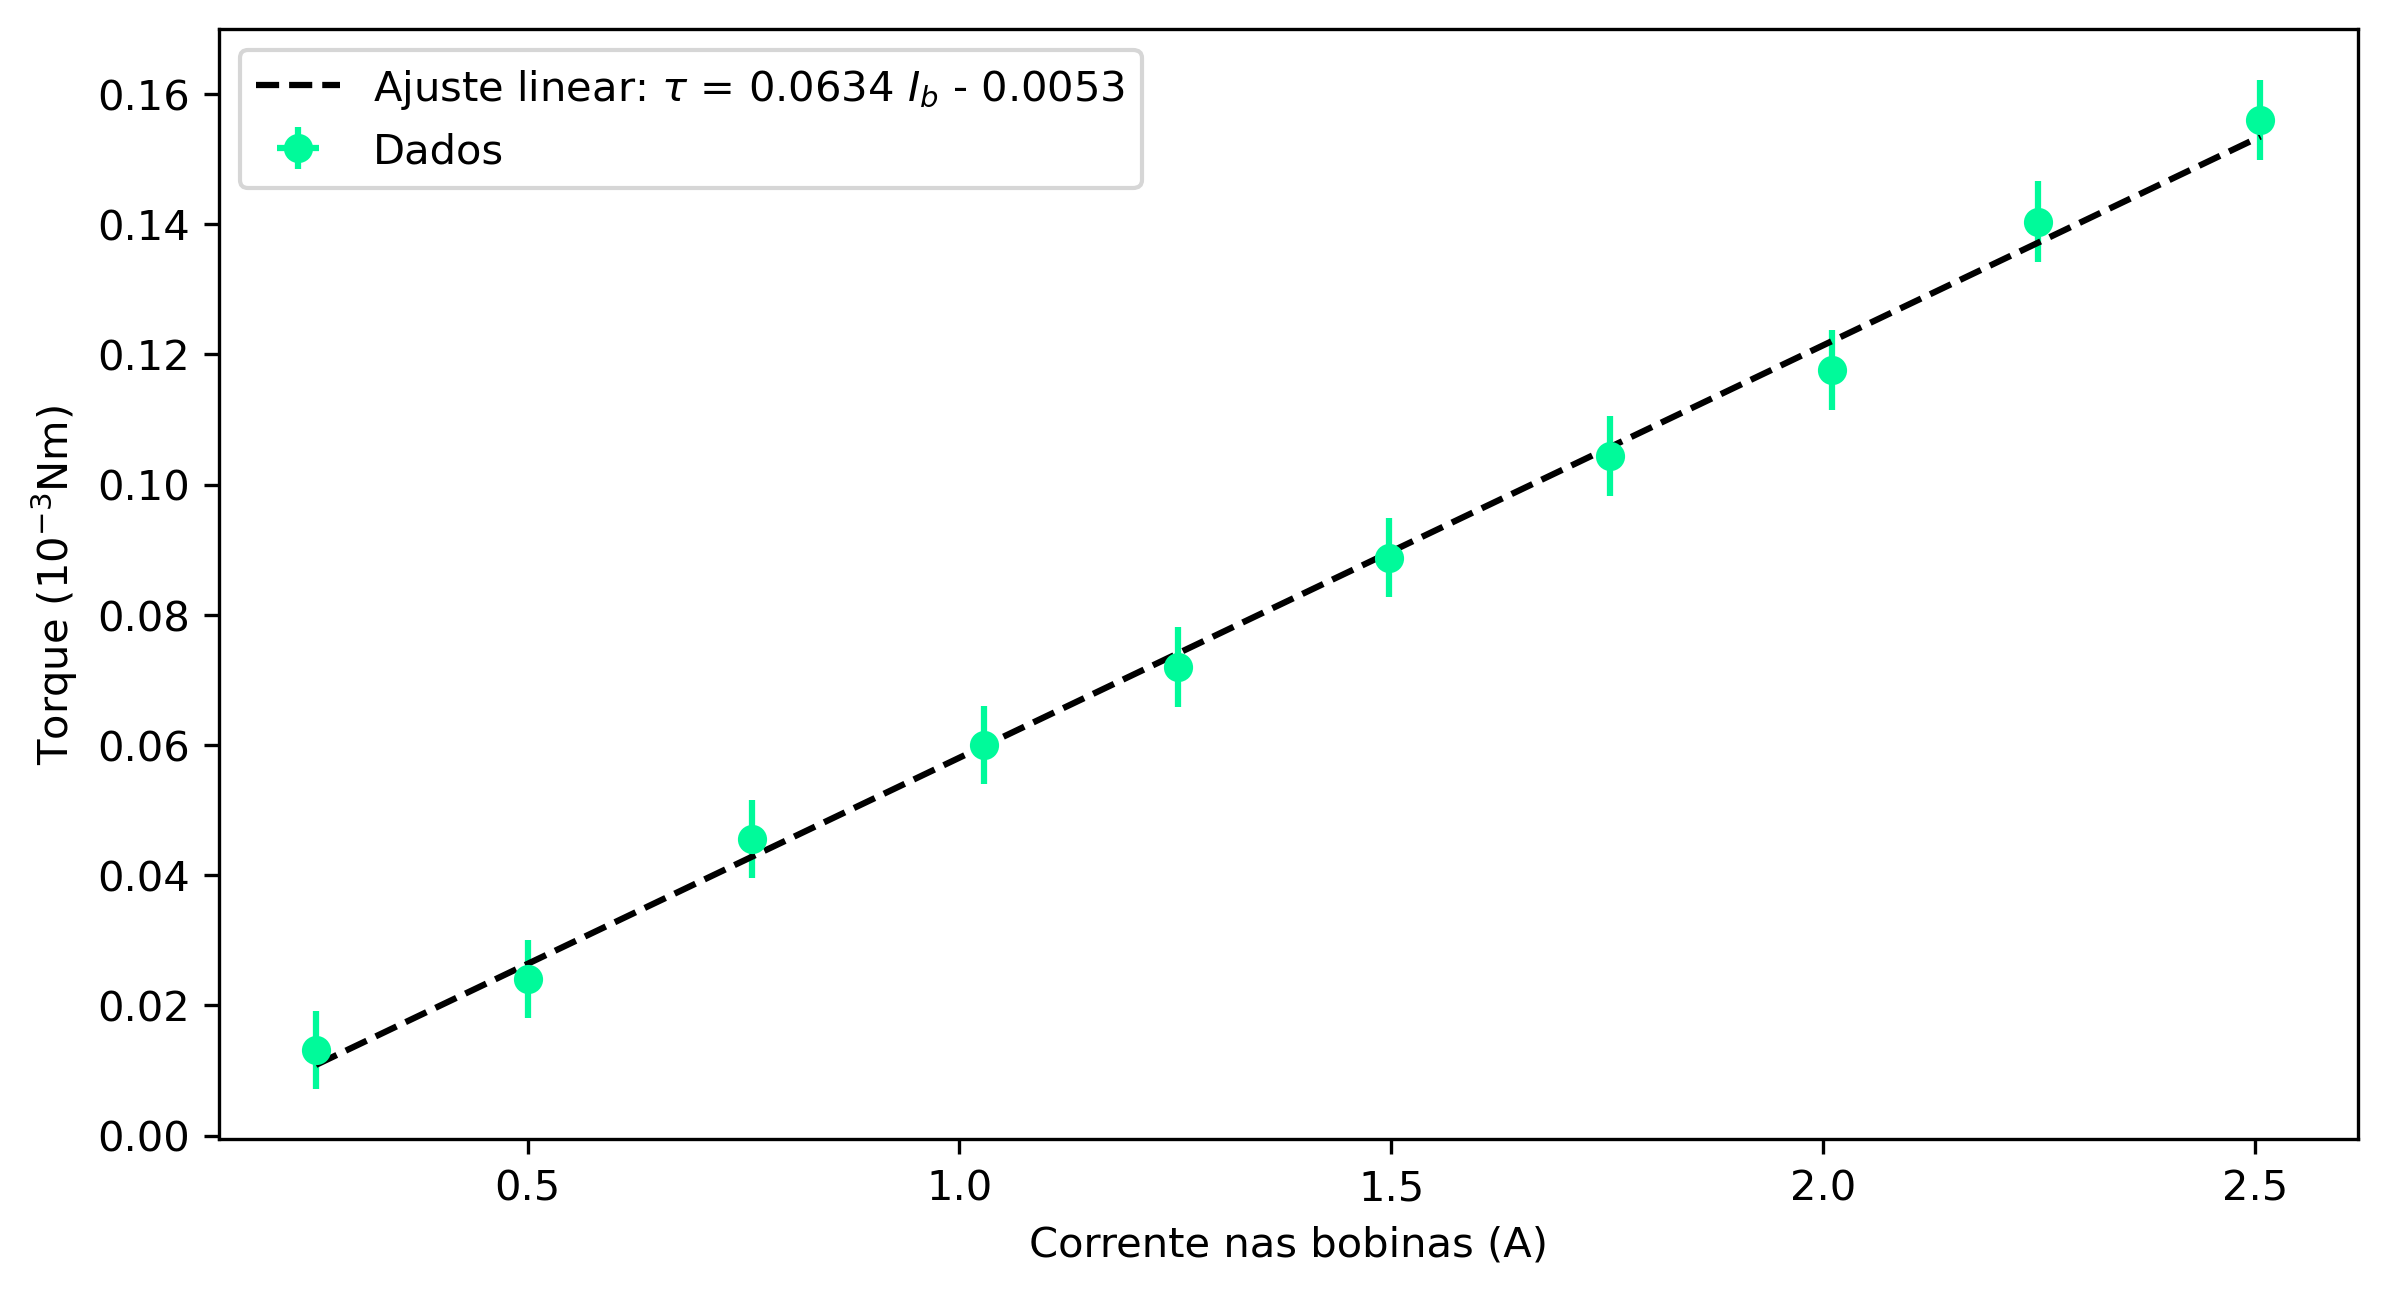

In [52]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.errorbar(i_espira,torque5,inctransf_T5,0, 'o', color = 'Mediumspringgreen', label = 'Dados')
plt.plot(i_espira,np.array(i_espira)*coef_angular5 + coef_linear5, color ='black', ls = '--', label = r'Ajuste linear: $\tau$ = %.4f $I_{b}$ - %.4f' % (coef_angular5,abs(coef_linear5)))
plt.xlabel('Corrente nas bobinas (A)')
plt.ylabel('Torque ($10^{-3}$Nm)')
plt.legend()
plt.show()

### Qualidade do ajuste

In [53]:
#Calulando chi^2_red
yhat5 = np.polyval(fitpars5, i_espira)
chi_squared5 = np.sum(((yhat5 - torque5)/inctransf_T5) ** 2)
chi2_red5 = chi_squared5/(len(i_espira)-2)

#Imprimindo o resultado
print("chi^2_red = %.3f" % chi2_red5)

chi^2_red = 0.206


### Gráfico de resíduos

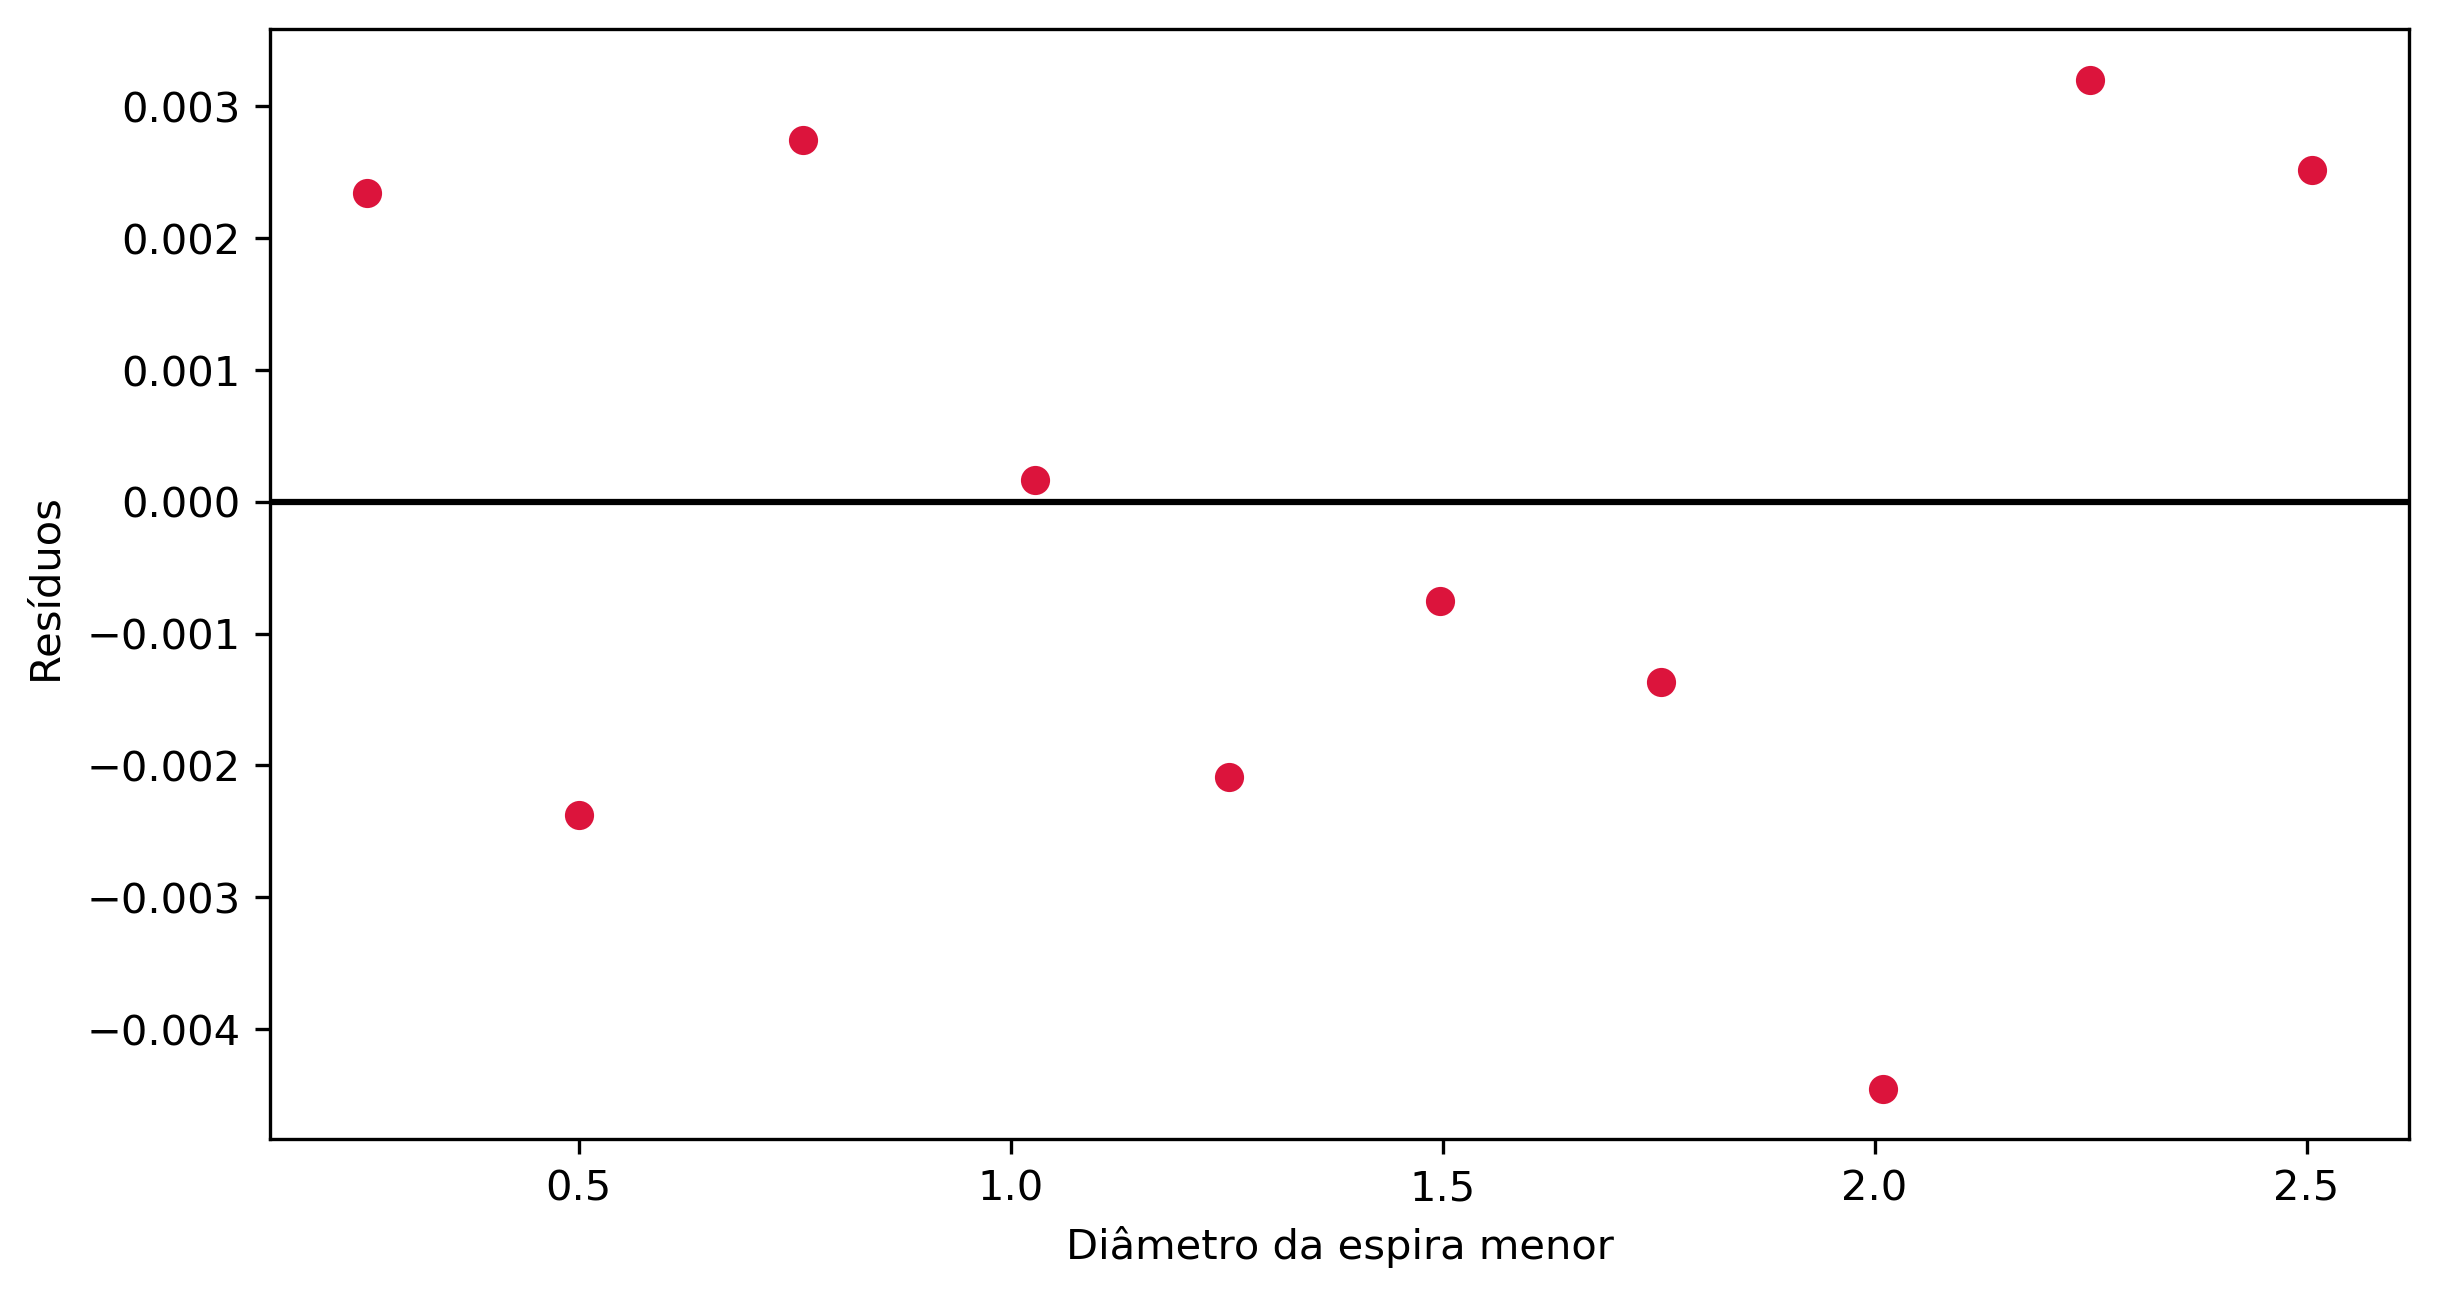

In [54]:
plt.figure(figsize = [9.2,4.9], dpi = 300) 
plt.scatter(np.array(i_espira),np.array(torque5)-np.array(i_espira)*coef_angular5 - coef_linear5, color = 'crimson')
plt.axhline(y=0, color='k', linestyle='-')
plt.ylabel("Resíduos ")
plt.xlabel('Diâmetro da espira menor')

plt.show()